In [1]:
%matplotlib notebook
import os
import numpy as np
import pandas as pd
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
from pyproj import Proj, transform
import matplotlib.pyplot as plt

# read additional scripts
from scripts.clip_area import clip_area
from scripts.read_landsat_images import read_landsat_images
from scripts.show_band import show_band

In [2]:
# Prepare list of folders / dates

def prepare_directories(main_folder):
    """Function prepares list with Landsat images directories in the given folder."""
    raw_list = os.listdir(main_folder)
    prepared_list = []
    for folder in raw_list:
        if ((folder.startswith('LC')) and not (folder.endswith('.tar.gz'))):
            prepared_list.append(main_folder + '/' + folder + '/')
    return prepared_list

def read_timestamp(folder):
    """Function reads date of acquisition of each Landsat 8 scene based on the folder with MTL file."""
    files = os.listdir(folder)
    for file in files:
        if file.startswith('LC') and file.endswith('MTL.txt'):
            address = folder + '/' + file
            with open(address, 'r') as f:
                for line in f:
                    line = ''.join(line.split())
                    if line.startswith('DATE_ACQUIRED='):
                        line = line.replace('DATE_ACQUIRED=', '')
                        return line

def prepare_dataframe(folders):
    """Function prepares dataframe with index column as a date of acquisition and the main column DIR which points
    to the directories with Landsat 8 images. Function takes one argument: the list of folders with Landsat 8 datasets."""
    
    # DataFrame preparation
    time_series = pd.DataFrame(folders, columns=['DIR'])
    time_series.index = time_series['DIR'].apply(lambda x: str(pd.to_datetime(read_timestamp(x)).date()))
    time_series.index.name = 'DATE'
    time_series = time_series.sort_index()
    return time_series

folder = 'data/rasters'
dataset = prepare_directories(folder)
dataset = prepare_dataframe(dataset)
dataset

DIR
DATE                                                         
2013-04-15  data/rasters/LC081900222013041501T1-SC20180614...
2013-05-01  data/rasters/LC081900222013050101T1-SC20180614...
2013-05-17  data/rasters/LC081900222013051701T1-SC20180614...
2013-06-18  data/rasters/LC081900222013061801T1-SC20180614...
2013-08-05  data/rasters/LC081900222013080501T1-SC20180614...
2013-09-06  data/rasters/LC081900222013090601T1-SC20180614...
2014-07-07  data/rasters/LC081900222014070701T1-SC20180614...
2015-04-21  data/rasters/LC081900222015042101T1-SC20180614...
2015-08-11  data/rasters/LC081900222015081101T1-SC20180614...
2017-04-10  data/rasters/LC081900222017041001T1-SC20180614...
2017-05-12  data/rasters/LC081900222017051201T1-SC20180614...
2017-05-28  data/rasters/LC081900222017052801T1-SC20180614...
2018-04-13  data/rasters/LC081900222018041301T1-SC20180614...
2018-05-31  data/rasters/LC081900222018053101RT-SC20180614...

In [3]:
# Prepare Area of Interest

def get_epsg_from_raster(raster_address):
    """Function reads raster data and gets its coordinate reference system. 
    Then it is converted to the European Petroleum Survey Group (EPSG) reference number."""
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg

In [34]:
class VectorData:
    """Class reads, stores, shows and reprojects vector shapefiles.
    It is initialized with filename.
    
    Class methods:
    get_vector_data(parameters='all', write_params=True) - method reads vector data and parse its parameters such as geometry,
    properties, crs and schema into dictionaries. Method may store parameters inside the object if write_params is set
    to True. Method returns desired parameters.
    reproject_geometry(destination_epsg, update=False) - method changes projection of each point inside the Polygon into
    projection given as an epsg number. It may update object geometry if the update parameter is set to True. Method returns
    reprojected geometry dictionary.
    show_vector_data(geometry=None) - method shows polygon. If geometry is not given then method uses class geometry."""
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """
        Function reads vector and its parameters and return them and / or store them inside the objects instance.
        input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(vector_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        """
        Function reprojects vector geometry and may update objects geometry.
        input 1: destination_epsg (string or int)
        input 2: update (bool)
        True: update object's geometry
        False: do not update object's geometry
        output: reprojected geometry as a dict"""
        
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        """
        Function shows vector geometry.
        input 1: geometry (dict, geometry retrieved as a parameter from the vector data type).
        If geometry is not given then method takes it from the objects instance."""
        
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

--- Object geometry, properties, crs and schema updated ---


<IPython.core.display.Javascript object>


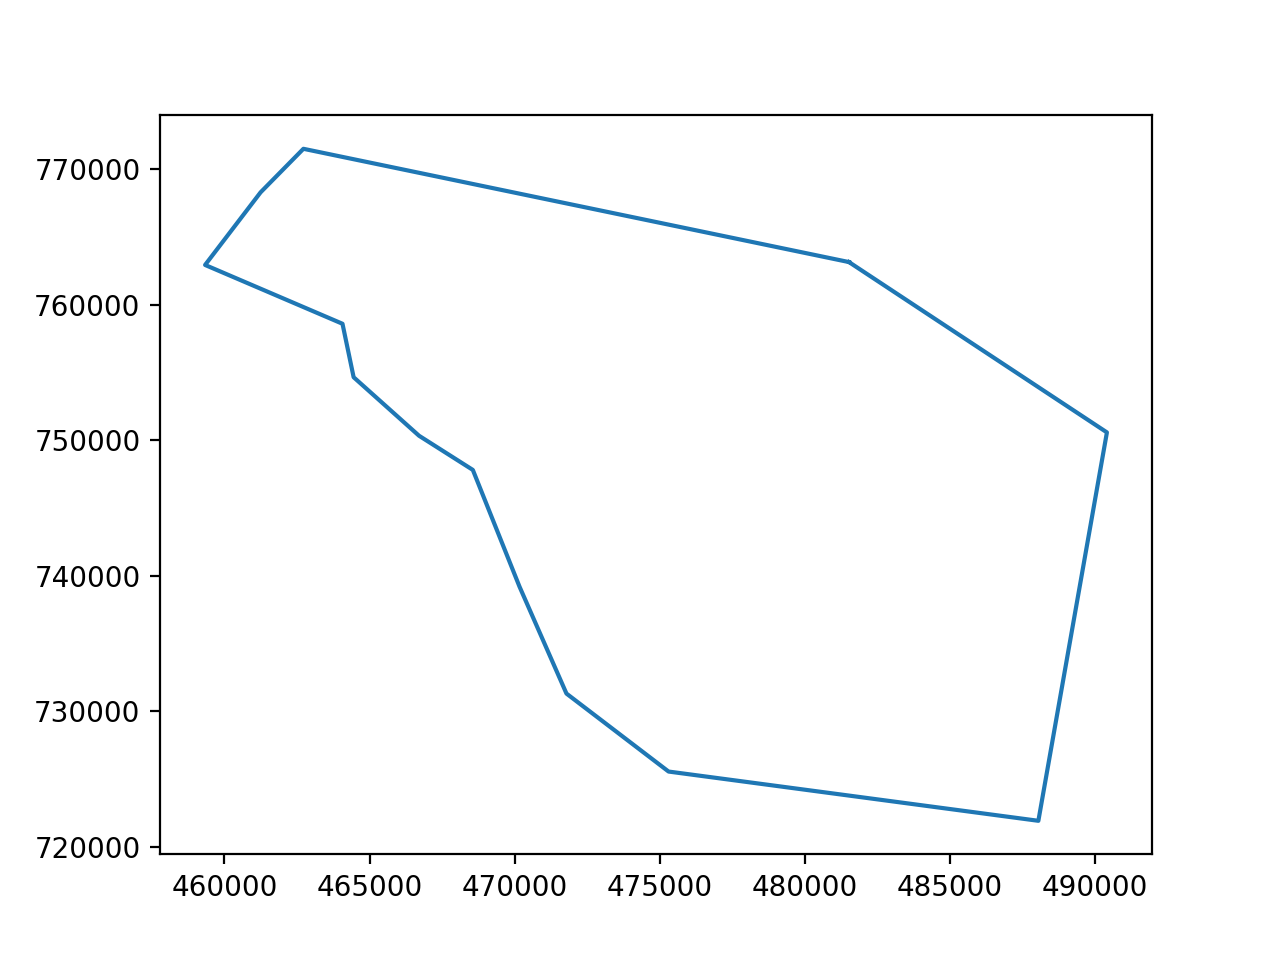

In [5]:
# Read and show county

vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)

In [7]:
# Get the destination crs from raster band

landsat_images = read_landsat_images(dataset['DIR'][0])
landsat_images

{1: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band1.tif',
 2: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band2.tif',
 3: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band3.tif',
 4: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band4.tif',
 5: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band5.tif',
 6: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band6.tif',
 7: 'data/rasters/LC081900222013041501T1-SC20180614122335/LC08_L1TP_190022_20130415_20170505_01_T1_sr_band7.tif'}

In [8]:
epsg = get_epsg_from_raster(landsat_images[5])

In [9]:
vn = vector_data.reproject_geometry(epsg, True)

In [10]:
file_for_clipped = 'data/clipped/clipped_test.tif'
clip_area(vn, landsat_images[5], file_for_clipped)

<IPython.core.display.Javascript object>


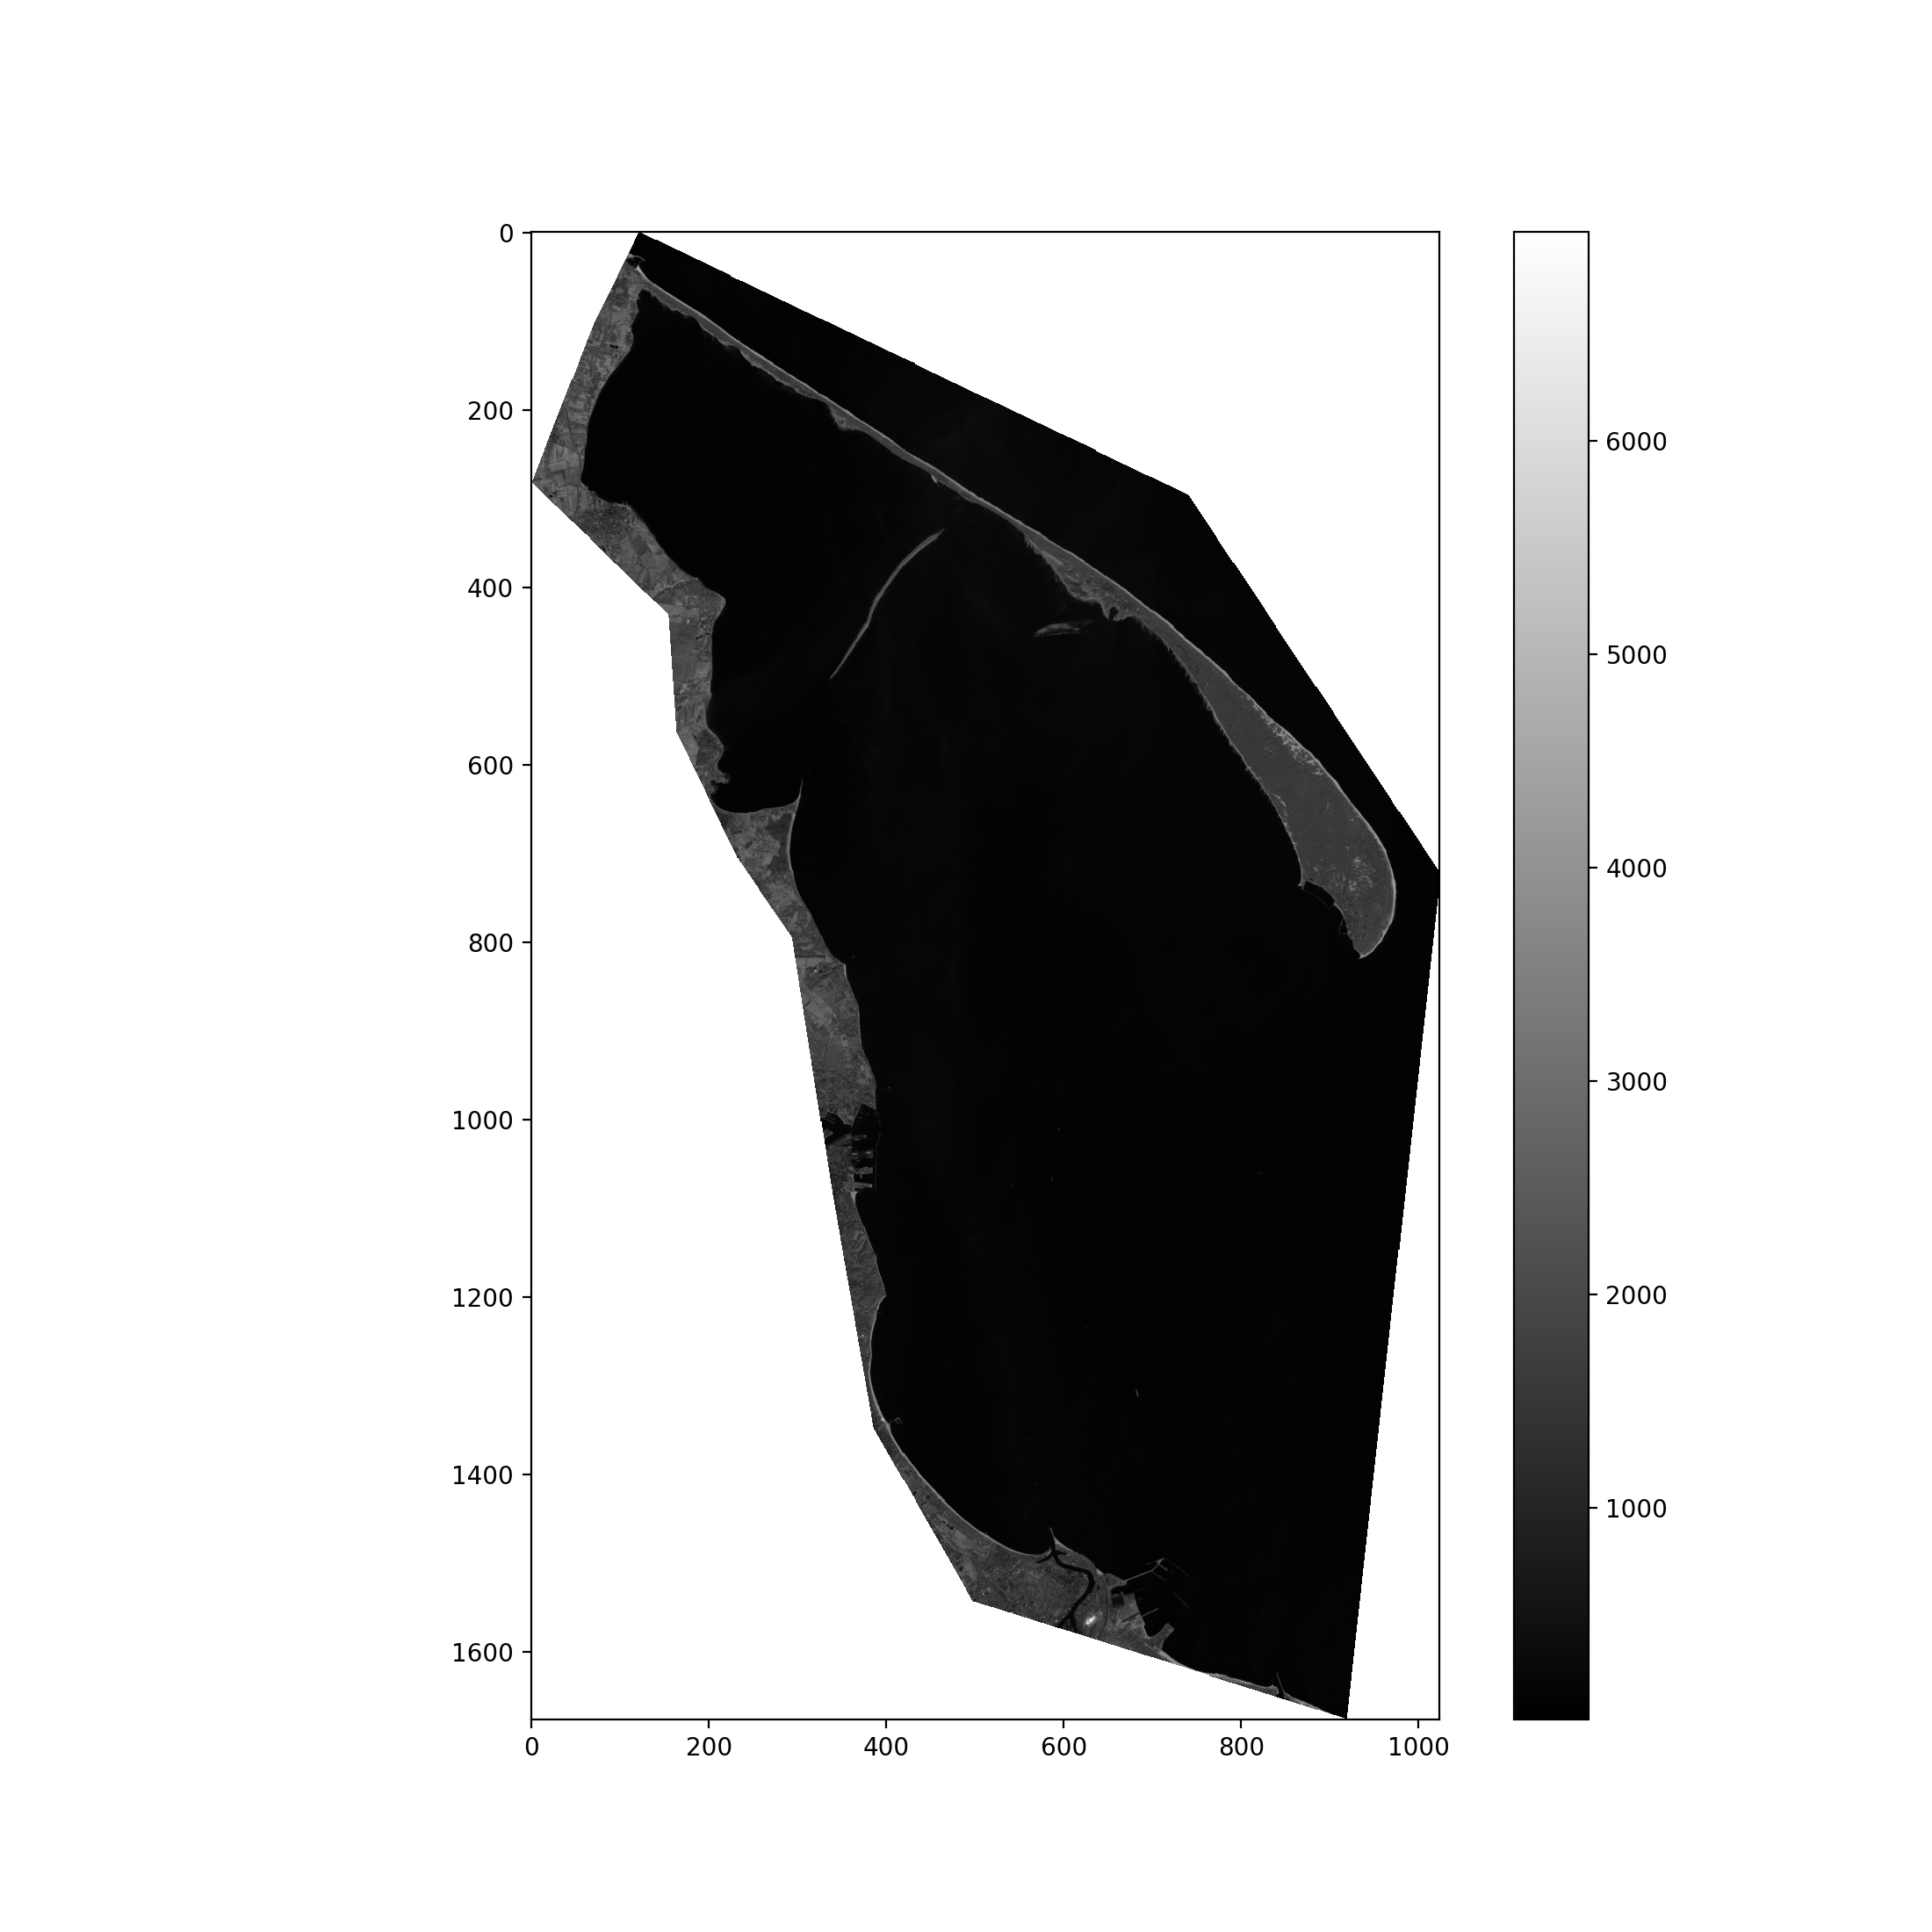

In [11]:
with rio.open(file_for_clipped) as f:
    band = f.read(1)
    band_crs = f.crs
    
show_band(band)

In [13]:
# Perform automatic clipping of bands 2, 4, 5 of each folder

def clip_all(df, clipping_vector, bands=(2, 3, 4), folder_name='clipped/'):
    """Function performs clipping of all Landsat 8 bands given in the DIR column of the df parameter.
    input 1: df - dataframe with DIR column where each record points to the directory with a Landsat bands
    input 2: clipping_vector - vector geometry which is used as a area of interest
    input 3: bands=(2, 3, 4) - tuple of bands which should be clipped. Bands 2, 3, 4 are used for the BGR image creation.
    input 4: folder_name='clipped/' - directory where all clipped bands should be stored.
    
    output: [correct, damaged, wrong_dates] - list of dicts with keys (dates) and values - correct images
    and damaged images. Damaged images were not process and they not exist in the destination folder."""
    
    data_range = len(dataset)
    damaged = {}
    correct = {}
    for i in range(0, data_range):
        date_str = dataset.index[i]
        images = read_landsat_images(dataset['DIR'][i])
        for band_number in bands:
            band_to_clip = images[band_number]
            filename = folder_name + 'LC_band' + str(band_number) + '_' + date_str + '.tif'
            try:
                clip_area(vn, band_to_clip, filename)
            except (rio.errors.WindowError, ValueError):
                print('\nPolygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.\n')
                try: 
                    damaged[date_str].append(filename)
                except KeyError:
                    damaged[date_str] = [filename]
                pass
            
            # Check file
            try: 
                damaged[date_str]
                print('File: {} not saved. Raster has not been clipped.'.format(
                filename))
            except KeyError:
                try:
                    with rio.open(filename) as tf:
                         pass
                except rio.RasterioIOError:
                    raise IOError('File was: {} not saved successfully'.format(
                    filename))
                else:
                    print('File: {} saved successfully'.format(
                    filename))
                    try: 
                        correct[date_str].append(filename)
                    except KeyError:
                        correct[date_str] = [filename]
    return [correct, damaged]
            
my_bands = (2, 4, 5)
my_folder_name = 'data/clipped/'
prepared_files = clip_all(dataset, vn, my_bands, my_folder_name)

File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-06-18.tif saved successfully
File: data/clipped/LC_band4_2013-06-18.tif saved successfully
File: data/clipped/LC_band5_2013-06-18.tif saved successfully
File: data/clipped/LC_band2_2013-08-05.tif saved successfully
File: data/clipped/LC_band4_2013-08-05.tif saved successfully
File: data/clipped/LC_band5_2013-08-05.tif saved successfully
File: data/clipped/LC_band2_2013-09-06.tif saved successfully
File: da

In [14]:
# Remove unused files from the dataframe, add to the dataframe addresses of used data

damaged_list = list(prepared_files[1].keys())
clean_dataset = dataset.drop(labels=damaged_list)
correct_df = pd.DataFrame.from_dict(prepared_files[0], orient='index')
clean_dataset = clean_dataset.join(correct_df)
clean_dataset

DIR  \
DATE                                                            
2013-04-15  data/rasters/LC081900222013041501T1-SC20180614...   
2013-05-01  data/rasters/LC081900222013050101T1-SC20180614...   
2013-05-17  data/rasters/LC081900222013051701T1-SC20180614...   
2013-06-18  data/rasters/LC081900222013061801T1-SC20180614...   
2013-08-05  data/rasters/LC081900222013080501T1-SC20180614...   
2013-09-06  data/rasters/LC081900222013090601T1-SC20180614...   
2014-07-07  data/rasters/LC081900222014070701T1-SC20180614...   
2015-04-21  data/rasters/LC081900222015042101T1-SC20180614...   
2015-08-11  data/rasters/LC081900222015081101T1-SC20180614...   
2017-04-10  data/rasters/LC081900222017041001T1-SC20180614...   
2017-05-12  data/rasters/LC081900222017051201T1-SC20180614...   
2017-05-28  data/rasters/LC081900222017052801T1-SC20180614...   
2018-04-13  data/rasters/LC081900222018041301T1-SC20180614...   
2018-05-31  data/rasters/LC081900222018053101RT-SC20180614...   

                                               0  \
DATE                                               
2013-04-15  data/clipped/LC_band2_2013-04-15.tif   
2013-05-01  data/clipped/LC_band2_2013-05-01.tif   
2013-05-17  data/clipped/LC_band2_2013-05-17.tif   
2013-06-18  data/clipped/LC_band2_2013-06-18.tif   
2013-08-05  data/clipped/LC_band2_2013-08-05.tif   
2013-09-06  data/clipped/LC_band2_2013-09-06.tif   
2014-07-07  data/clipped/LC_band2_2014-07-07.tif   
2015-04-21  data/clipped/LC_band2_2015-04-21.tif   
2015-08-11  data/clipped/LC_band2_2015-08-11.tif   
2017-04-10  data/clipped/LC_band2_2017-04-10.tif   
2017-05-12  data/clipped/LC_band2_2017-05-12.tif   
2017-05-28  data/clipped/LC_band2_2017-05-28.tif   
2018-04-13  data/clipped/LC_band2_2018-04-13.tif   
2018-05-31  data/clipped/LC_band2_2018-05-31.tif   

                                               1  \
DATE                                               
2013-04-15  data/clipped/LC_band4_2013-04-15.tif   
2013-05-01  data/clipped/LC_band4_2013-05-01.tif   
2013-05-17  data/clipped/LC_band4_2013-05-17.tif   
2013-06-18  data/clipped/LC_band4_2013-06-18.tif   
2013-08-05  data/clipped/LC_band4_2013-08-05.tif   
2013-09-06  data/clipped/LC_band4_2013-09-06.tif   
2014-07-07  data/clipped/LC_band4_2014-07-07.tif   
2015-04-21  data/clipped/LC_band4_2015-04-21.tif   
2015-08-11  data/clipped/LC_band4_2015-08-11.tif   
2017-04-10  data/clipped/LC_band4_2017-04-10.tif   
2017-05-12  data/clipped/LC_band4_2017-05-12.tif   
2017-05-28  data/clipped/LC_band4_2017-05-28.tif   
2018-04-13  data/clipped/LC_band4_2018-04-13.tif   
2018-05-31  data/clipped/LC_band4_2018-05-31.tif   

                                               2  
DATE                                              
2013-04-15  data/clipped/LC_band5_2013-04-15.tif  
2013-05-01  data/clipped/LC_band5_2013-05-01.tif  
2013-05-17  data/clipped/LC_band5_2013-05-17.tif  
2013-06-18  data/clipped/LC_band5_2013-06-18.tif  
2013-08-05  data/clipped/LC_band5_2013-08-05.tif  
2013-09-06  data/clipped/LC_band5_2013-09-06.tif  
2014-07-07  data/clipped/LC_band5_2014-07-07.tif  
2015-04-21  data/clipped/LC_band5_2015-04-21.tif  
2015-08-11  data/clipped/LC_band5_2015-08-11.tif  
2017-04-10  data/clipped/LC_band5_2017-04-10.tif  
2017-05-12  data/clipped/LC_band5_2017-05-12.tif  
2017-05-28  data/clipped/LC_band5_2017-05-28.tif  
2018-04-13  data/clipped/LC_band5_2018-04-13.tif  
2018-05-31  data/clipped/LC_band5_2018-05-31.tif

In [15]:
# Calculate mean EVI for each of remaining dates

def calculate_evi(bands):
    """Function calculates evi indicator from given data and returns it as an evi map"""
    # sort bands based on their names
    bands.sort() # band 2, band 4, band 5
            
    with rio.open(bands[2]) as a:
        nir_band = (a.read()[0]/10000).astype(np.float)
    with rio.open(bands[1]) as b:
        r_band = (b.read()[0]/10000).astype(np.float)
    with rio.open(bands[0]) as c:
        b_band = (c.read()[0]/10000).astype(np.float)

    numerator = nir_band - r_band
    g = 2.5
    c1 = 6
    c2 = 7.5
    l = 1
    denominator = nir_band + c1 * r_band - c2 * b_band + l
    evi = g * (numerator / denominator)
    evi[evi > 1] = 1
    return evi

In [16]:
clean_dataset['EVI'] = clean_dataset.apply(lambda x: np.nanmean(calculate_evi([x[0], x[1], x[2]])), axis=1)

In [17]:
clean_dataset

DIR  \
DATE                                                            
2013-04-15  data/rasters/LC081900222013041501T1-SC20180614...   
2013-05-01  data/rasters/LC081900222013050101T1-SC20180614...   
2013-05-17  data/rasters/LC081900222013051701T1-SC20180614...   
2013-06-18  data/rasters/LC081900222013061801T1-SC20180614...   
2013-08-05  data/rasters/LC081900222013080501T1-SC20180614...   
2013-09-06  data/rasters/LC081900222013090601T1-SC20180614...   
2014-07-07  data/rasters/LC081900222014070701T1-SC20180614...   
2015-04-21  data/rasters/LC081900222015042101T1-SC20180614...   
2015-08-11  data/rasters/LC081900222015081101T1-SC20180614...   
2017-04-10  data/rasters/LC081900222017041001T1-SC20180614...   
2017-05-12  data/rasters/LC081900222017051201T1-SC20180614...   
2017-05-28  data/rasters/LC081900222017052801T1-SC20180614...   
2018-04-13  data/rasters/LC081900222018041301T1-SC20180614...   
2018-05-31  data/rasters/LC081900222018053101RT-SC20180614...   

                                               0  \
DATE                                               
2013-04-15  data/clipped/LC_band2_2013-04-15.tif   
2013-05-01  data/clipped/LC_band2_2013-05-01.tif   
2013-05-17  data/clipped/LC_band2_2013-05-17.tif   
2013-06-18  data/clipped/LC_band2_2013-06-18.tif   
2013-08-05  data/clipped/LC_band2_2013-08-05.tif   
2013-09-06  data/clipped/LC_band2_2013-09-06.tif   
2014-07-07  data/clipped/LC_band2_2014-07-07.tif   
2015-04-21  data/clipped/LC_band2_2015-04-21.tif   
2015-08-11  data/clipped/LC_band2_2015-08-11.tif   
2017-04-10  data/clipped/LC_band2_2017-04-10.tif   
2017-05-12  data/clipped/LC_band2_2017-05-12.tif   
2017-05-28  data/clipped/LC_band2_2017-05-28.tif   
2018-04-13  data/clipped/LC_band2_2018-04-13.tif   
2018-05-31  data/clipped/LC_band2_2018-05-31.tif   

                                               1  \
DATE                                               
2013-04-15  data/clipped/LC_band4_2013-04-15.tif   
2013-05-01  data/clipped/LC_band4_2013-05-01.tif   
2013-05-17  data/clipped/LC_band4_2013-05-17.tif   
2013-06-18  data/clipped/LC_band4_2013-06-18.tif   
2013-08-05  data/clipped/LC_band4_2013-08-05.tif   
2013-09-06  data/clipped/LC_band4_2013-09-06.tif   
2014-07-07  data/clipped/LC_band4_2014-07-07.tif   
2015-04-21  data/clipped/LC_band4_2015-04-21.tif   
2015-08-11  data/clipped/LC_band4_2015-08-11.tif   
2017-04-10  data/clipped/LC_band4_2017-04-10.tif   
2017-05-12  data/clipped/LC_band4_2017-05-12.tif   
2017-05-28  data/clipped/LC_band4_2017-05-28.tif   
2018-04-13  data/clipped/LC_band4_2018-04-13.tif   
2018-05-31  data/clipped/LC_band4_2018-05-31.tif   

                                               2       EVI  
DATE                                                        
2013-04-15  data/clipped/LC_band5_2013-04-15.tif  0.002378  
2013-05-01  data/clipped/LC_band5_2013-05-01.tif  0.007393  
2013-05-17  data/clipped/LC_band5_2013-05-17.tif  0.013561  
2013-06-18  data/clipped/LC_band5_2013-06-18.tif  0.023207  
2013-08-05  data/clipped/LC_band5_2013-08-05.tif  0.016153  
2013-09-06  data/clipped/LC_band5_2013-09-06.tif  0.015128  
2014-07-07  data/clipped/LC_band5_2014-07-07.tif  0.015862  
2015-04-21  data/clipped/LC_band5_2015-04-21.tif  0.007355  
2015-08-11  data/clipped/LC_band5_2015-08-11.tif  0.012914  
2017-04-10  data/clipped/LC_band5_2017-04-10.tif  0.006432  
2017-05-12  data/clipped/LC_band5_2017-05-12.tif  0.009416  
2017-05-28  data/clipped/LC_band5_2017-05-28.tif  0.016415  
2018-04-13  data/clipped/LC_band5_2018-04-13.tif -0.001614  
2018-05-31  data/clipped/LC_band5_2018-05-31.tif  0.017668

<IPython.core.display.Javascript object>


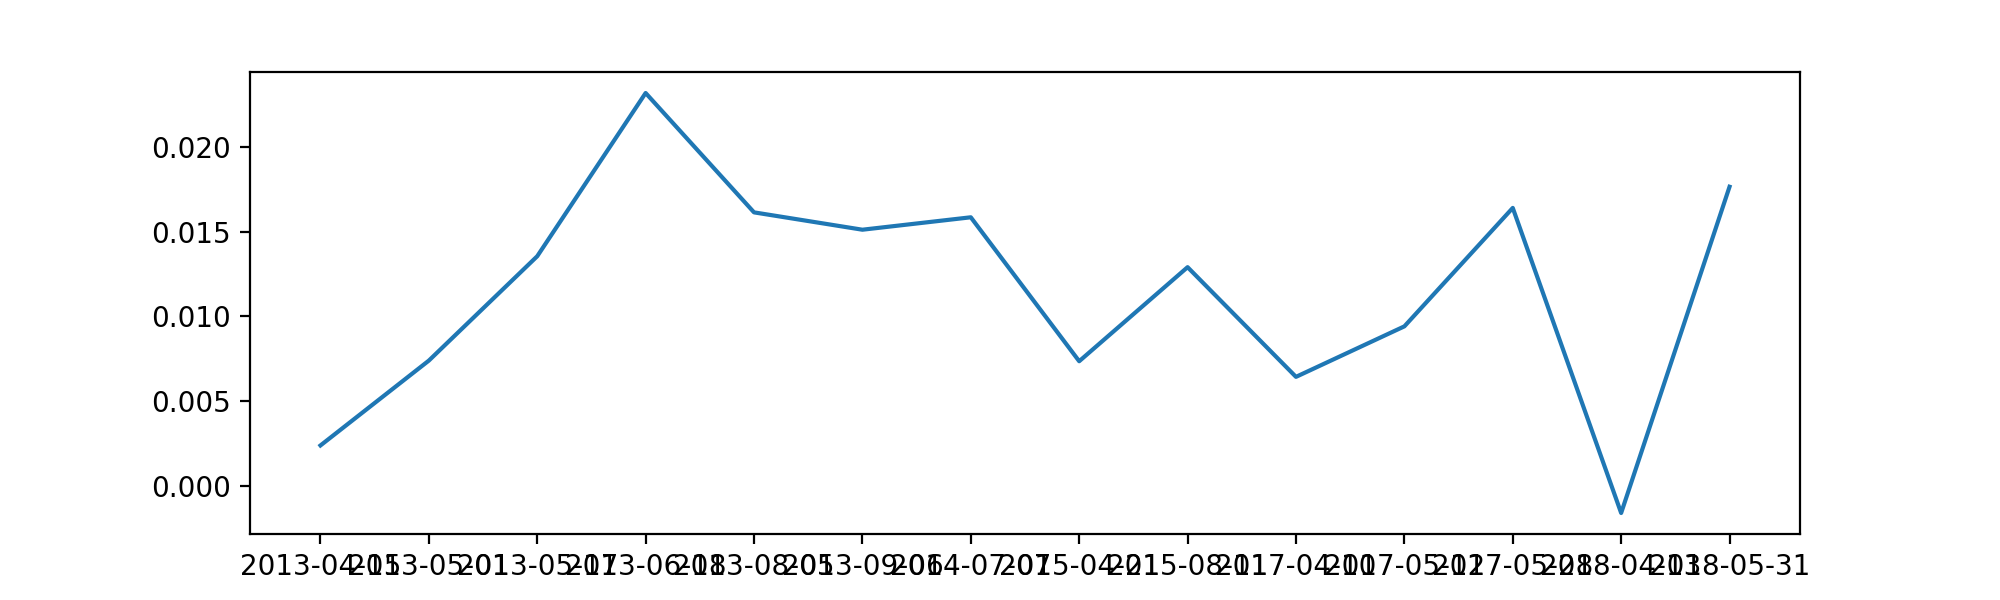

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(clean_dataset.index, clean_dataset['EVI'])
plt.show()

<IPython.core.display.Javascript object>


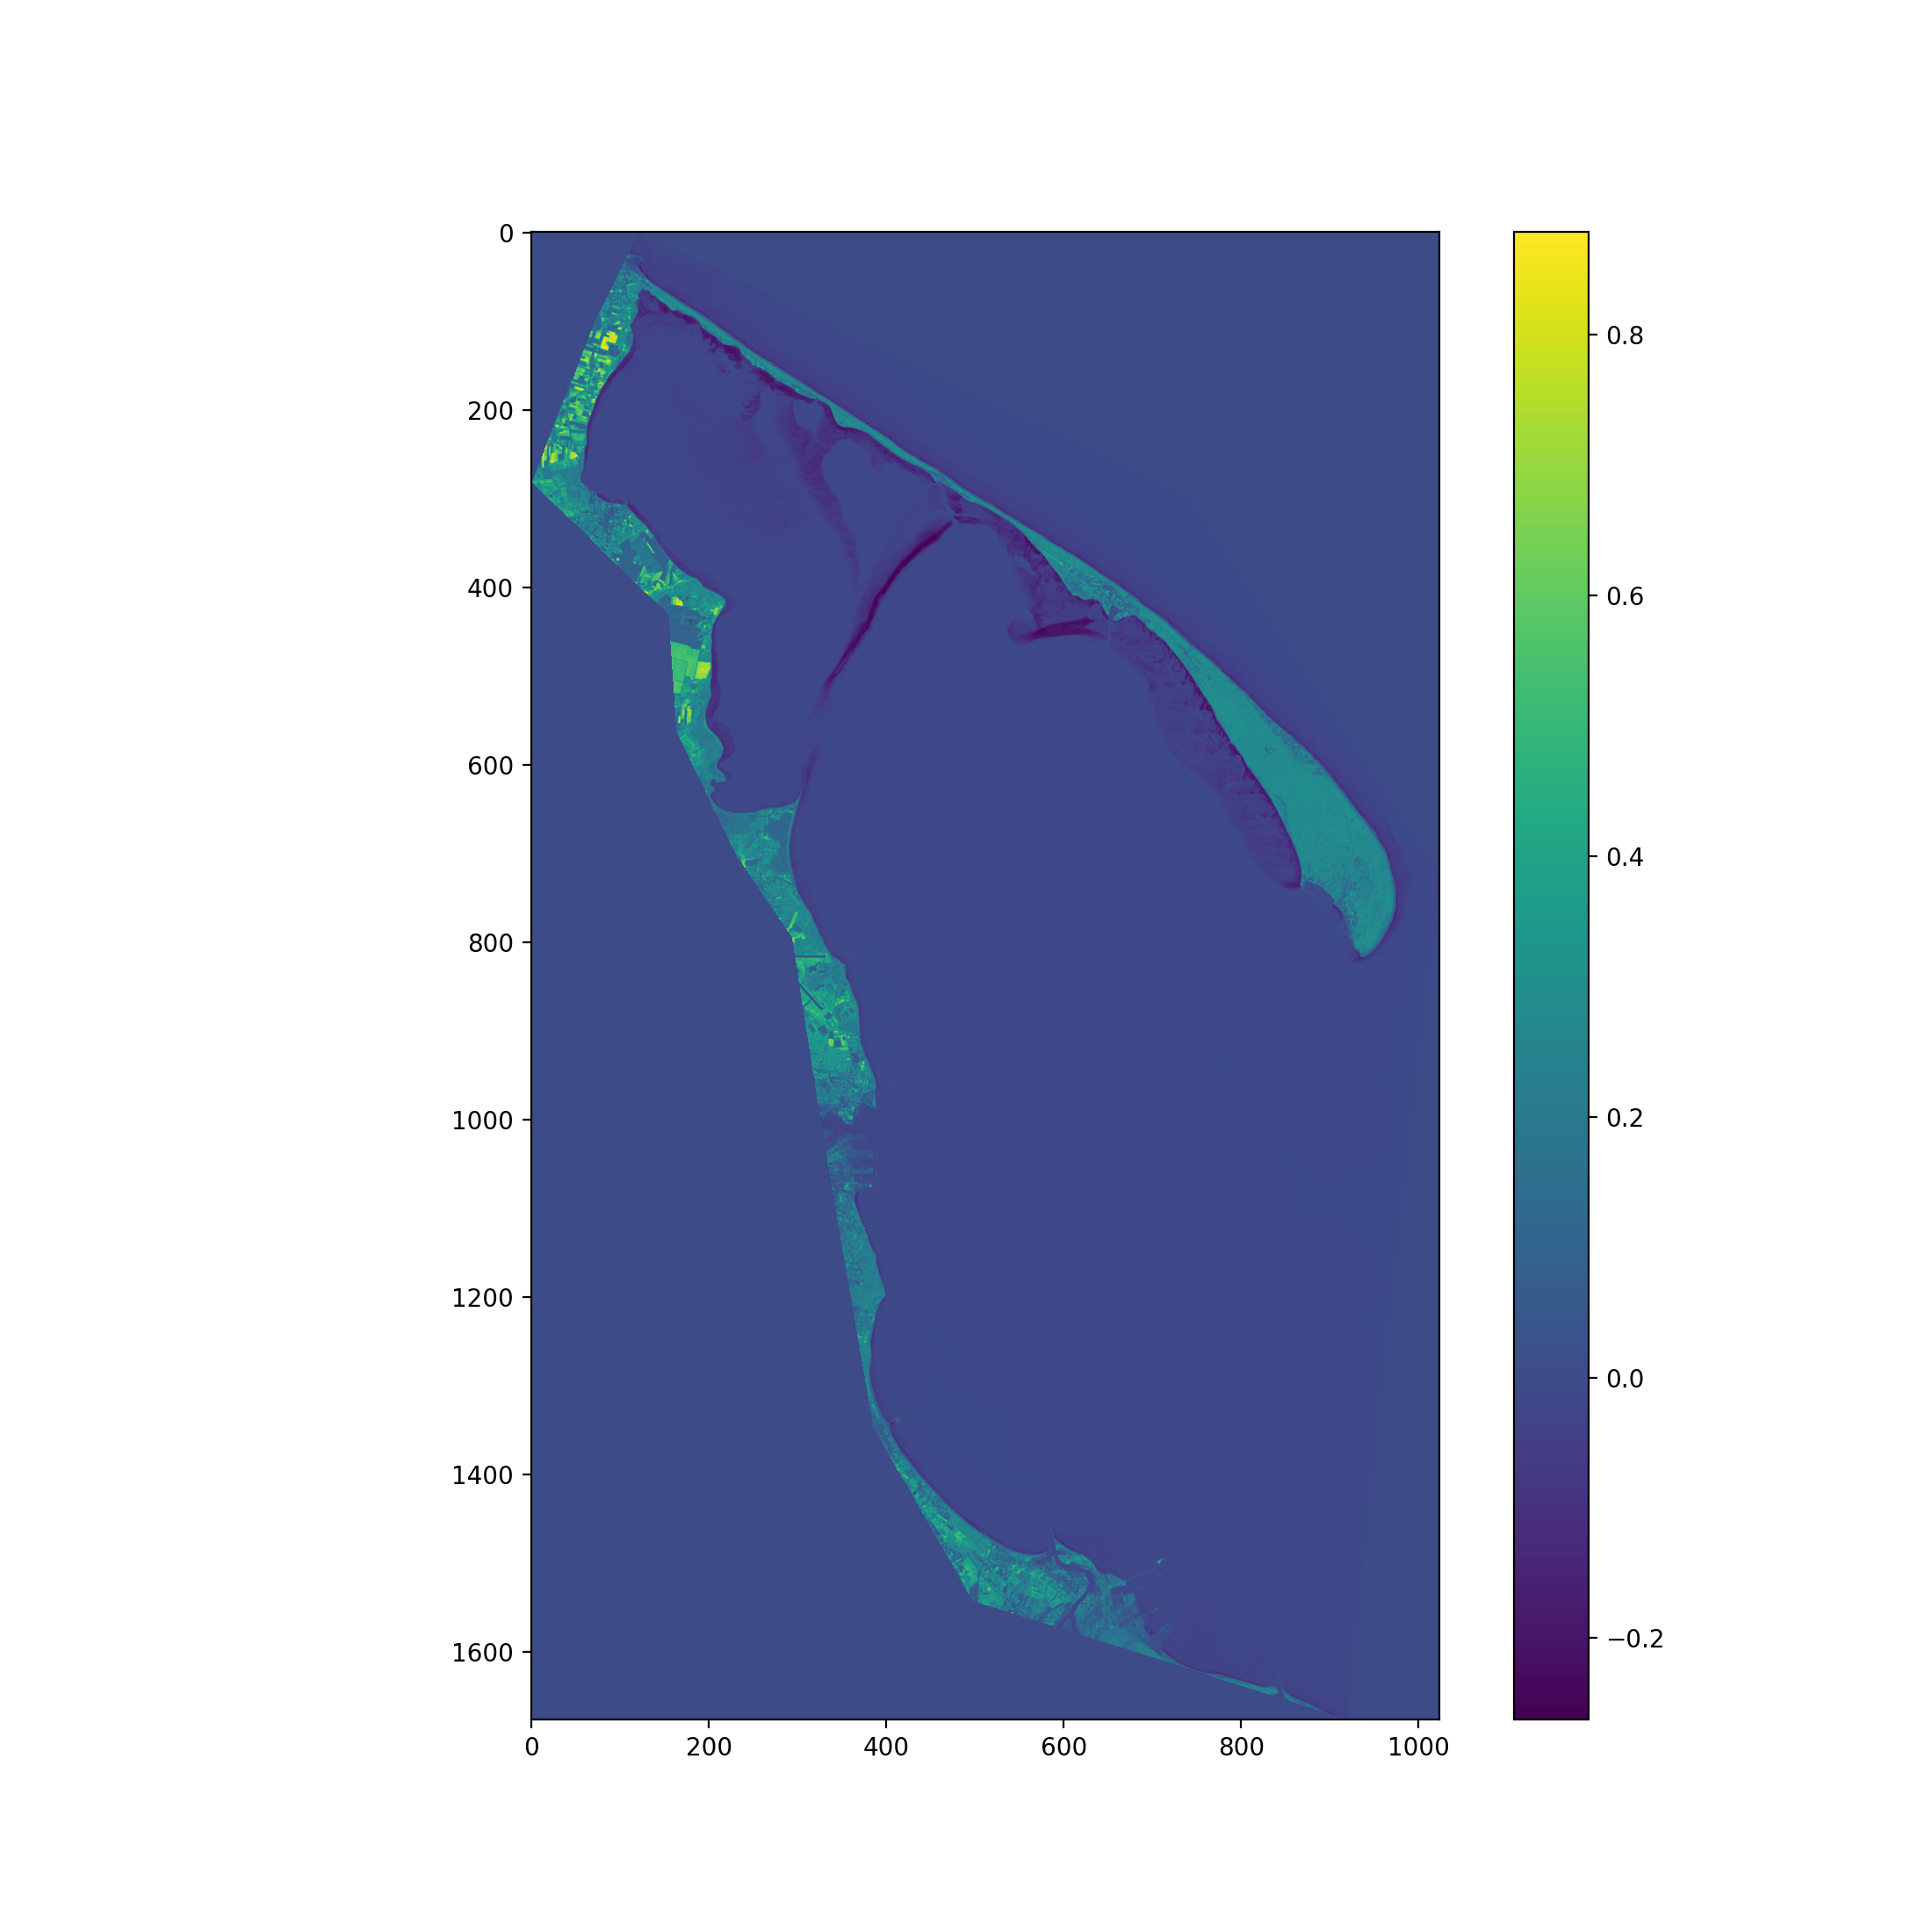

In [28]:
bands = [clean_dataset[clean_dataset.index == '2015-04-21'][0][0],
        clean_dataset[clean_dataset.index == '2015-04-21'][1][0],
        clean_dataset[clean_dataset.index == '2015-04-21'][2][0]]

before = calculate_evi(bands)
show_band(before, color_map='viridis', remove_negative=False)

<IPython.core.display.Javascript object>


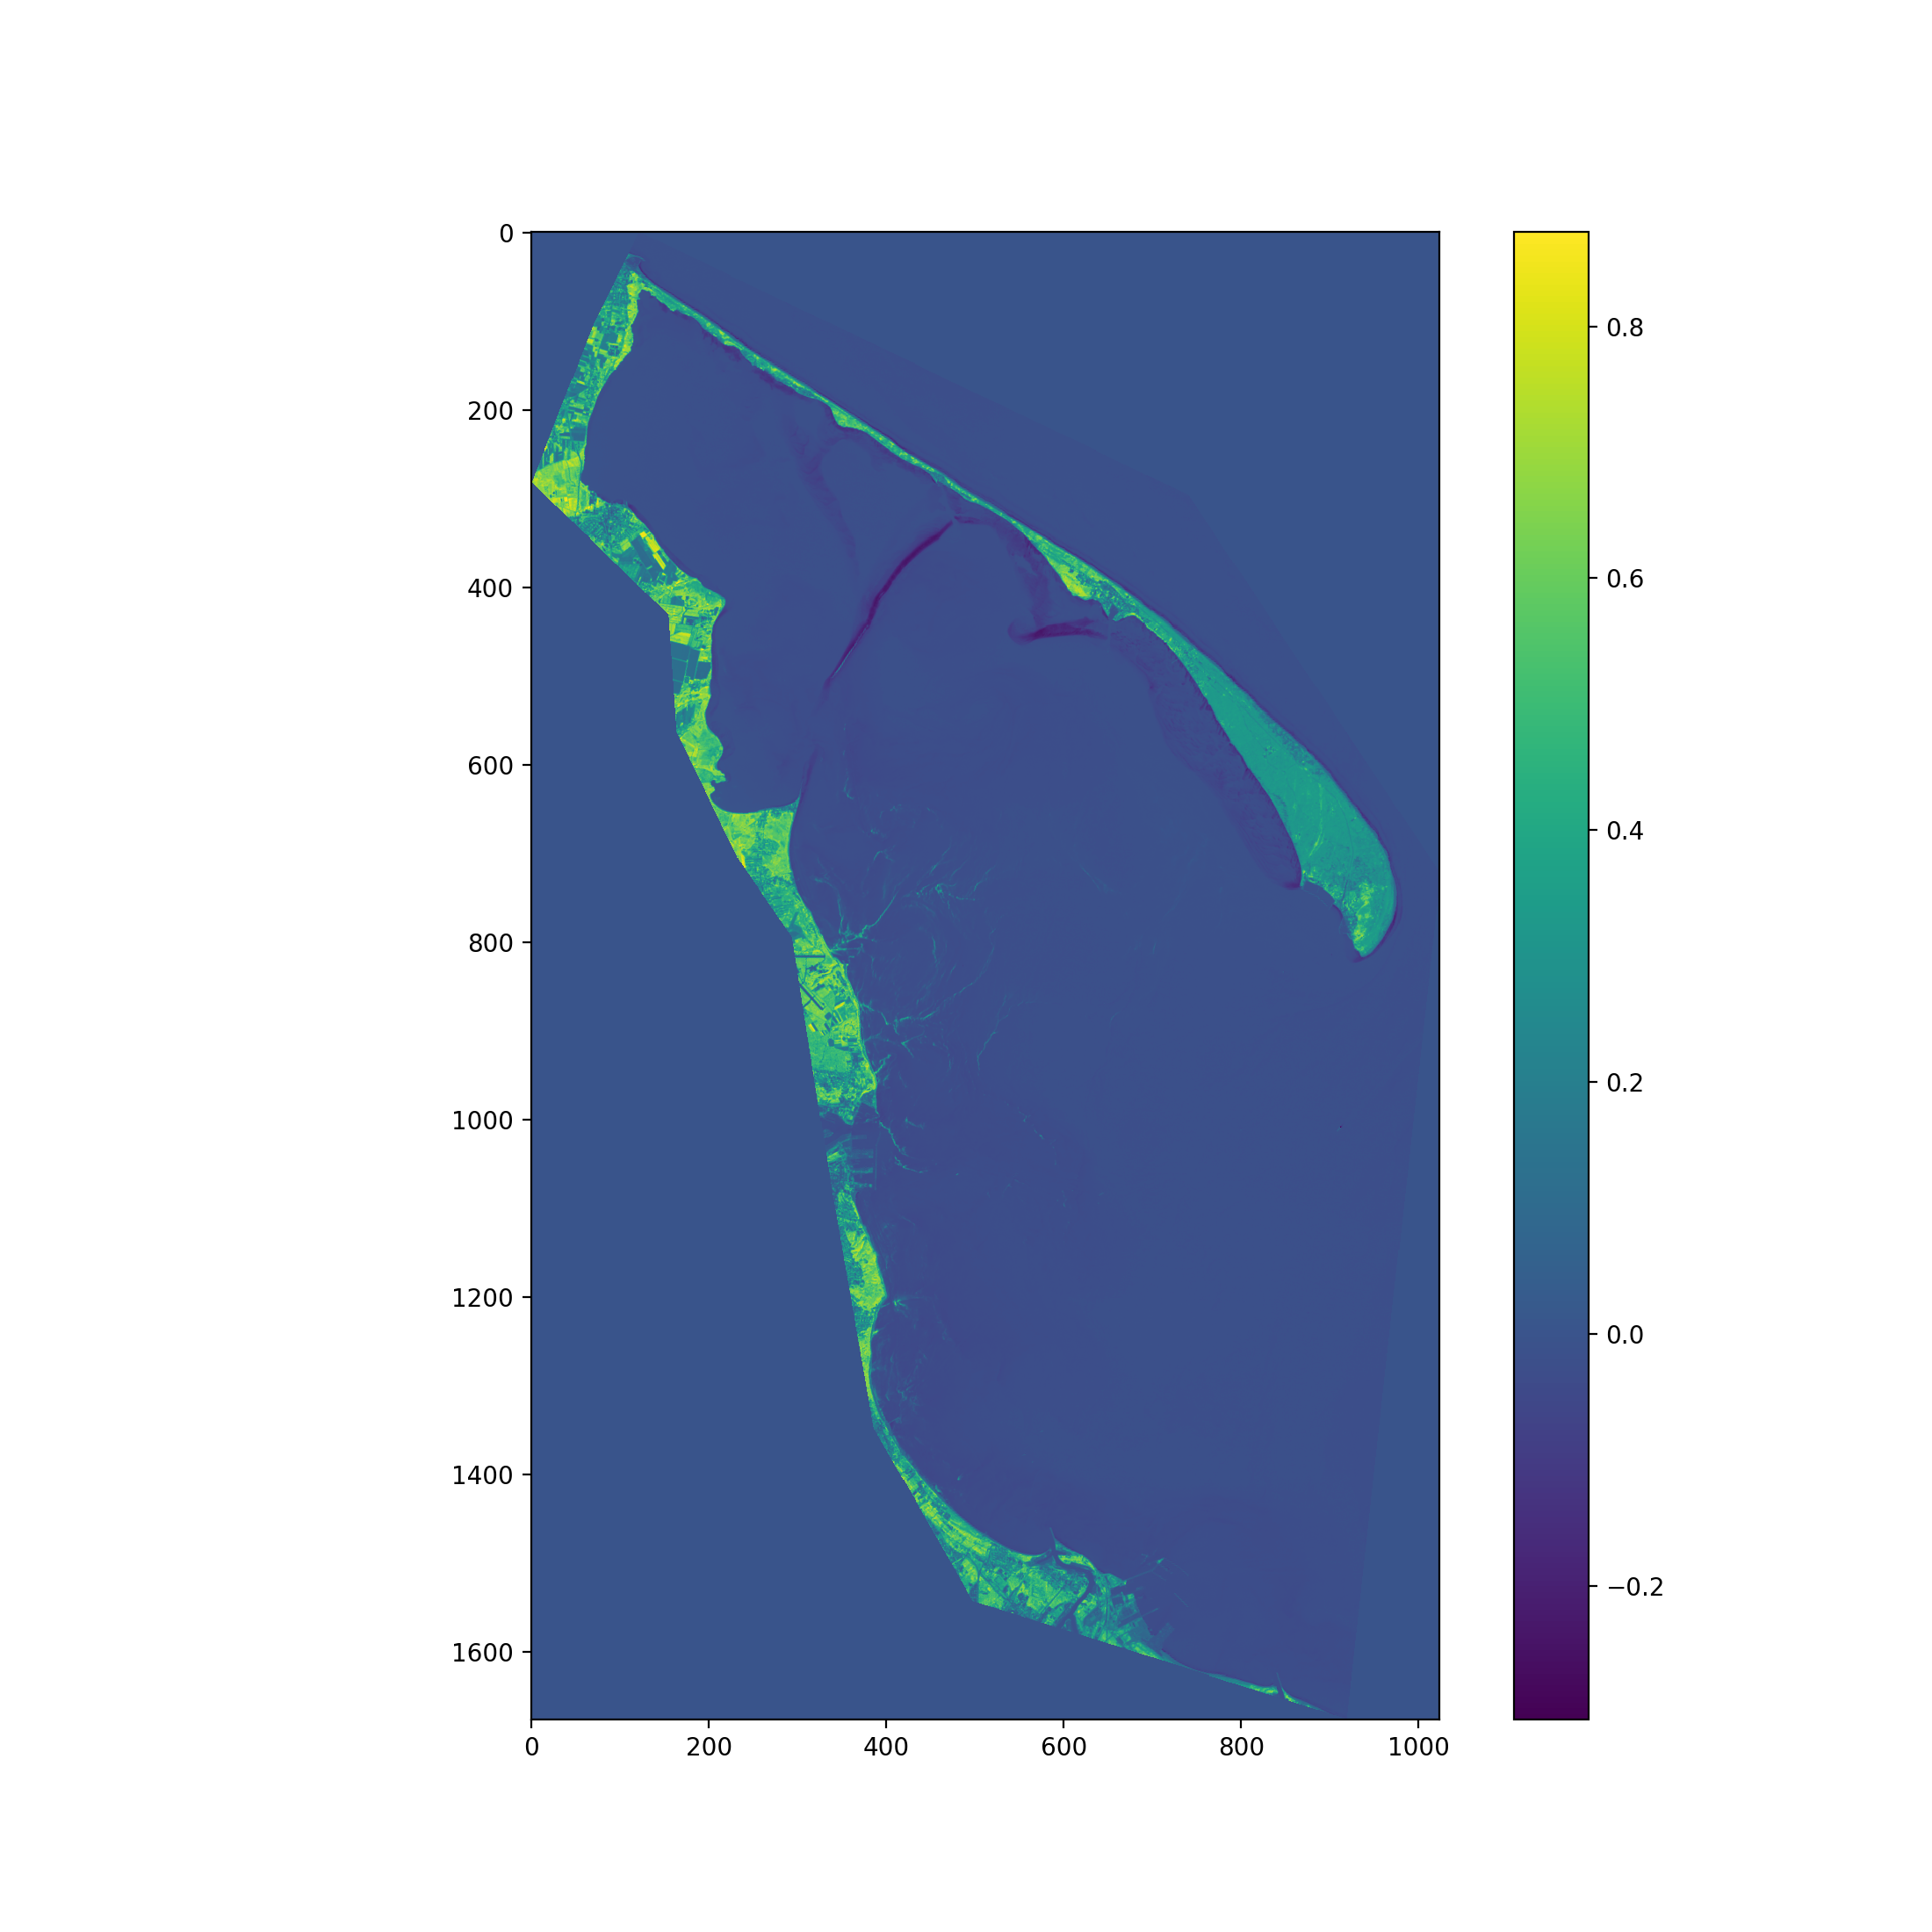

In [19]:
bands = [clean_dataset[clean_dataset.index == '2015-08-11'][0][0],
        clean_dataset[clean_dataset.index == '2015-08-11'][1][0],
        clean_dataset[clean_dataset.index == '2015-08-11'][2][0]]

after = calculate_evi(bands)
show_band(after, color_map='viridis', remove_negative=False)

<IPython.core.display.Javascript object>


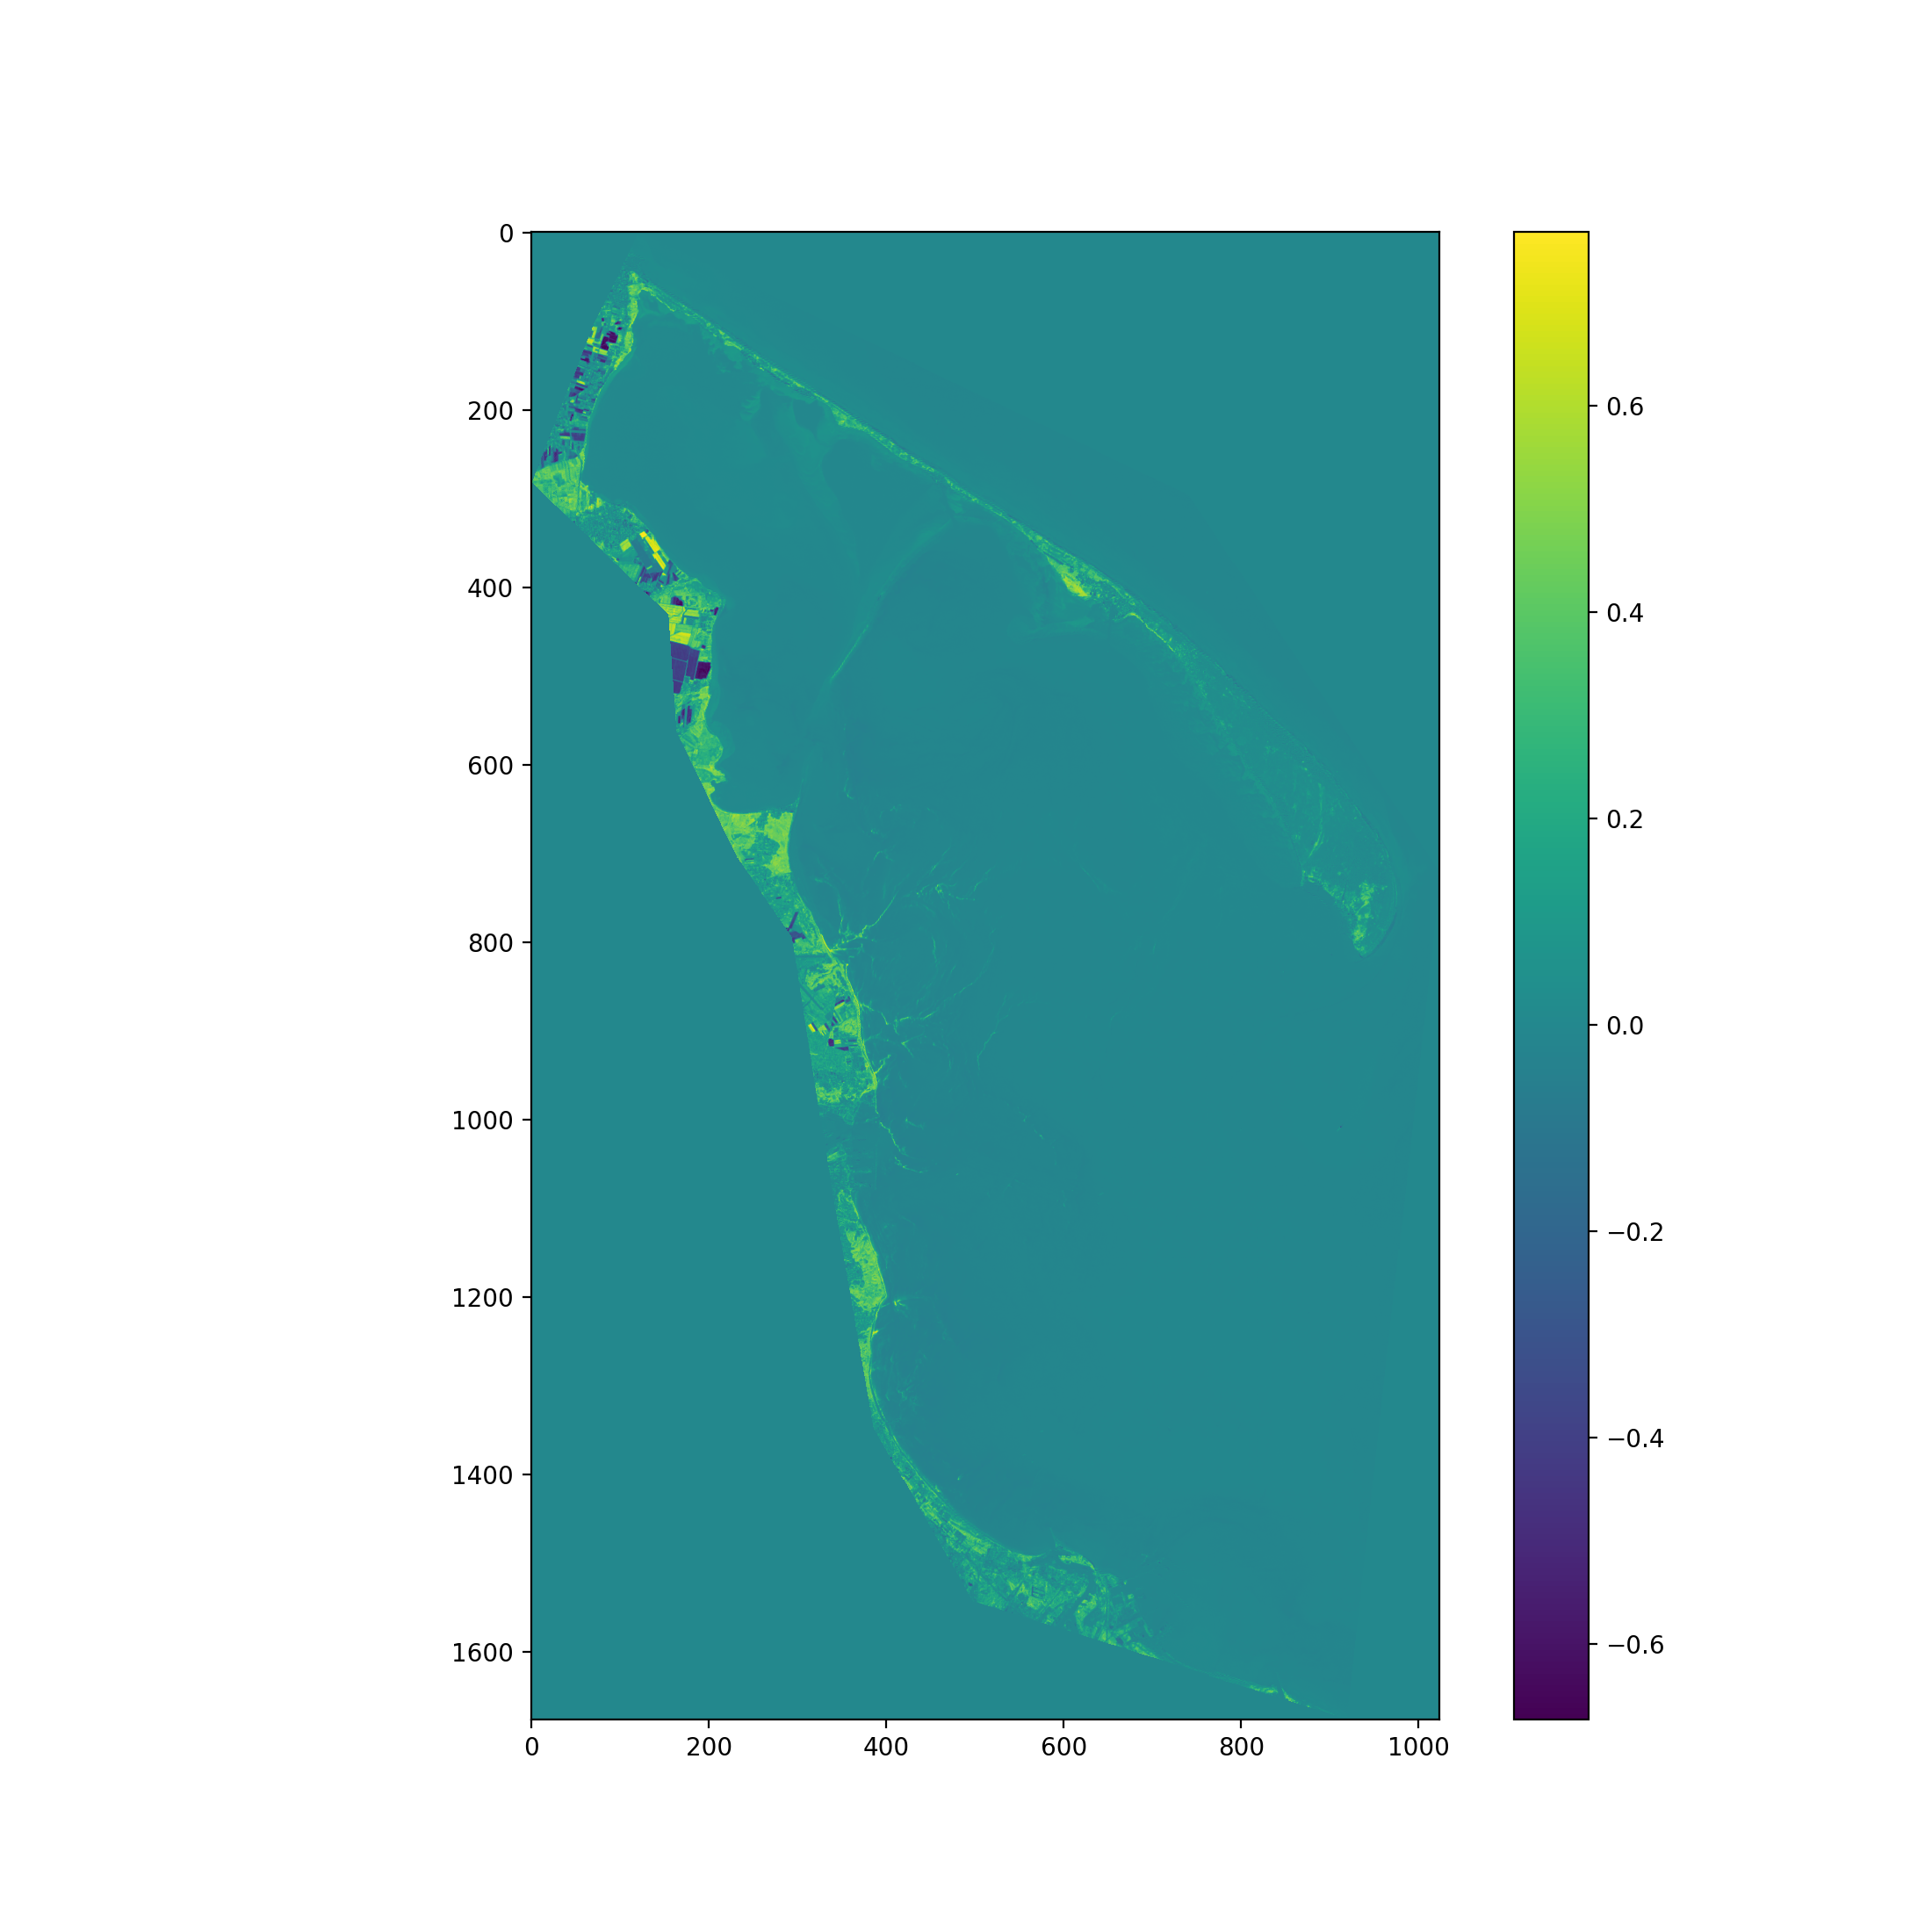

In [29]:
differences = after - before
show_band(differences, color_map='viridis', remove_negative=False)

--- Object geometry, properties, crs and schema updated ---


<IPython.core.display.Javascript object>


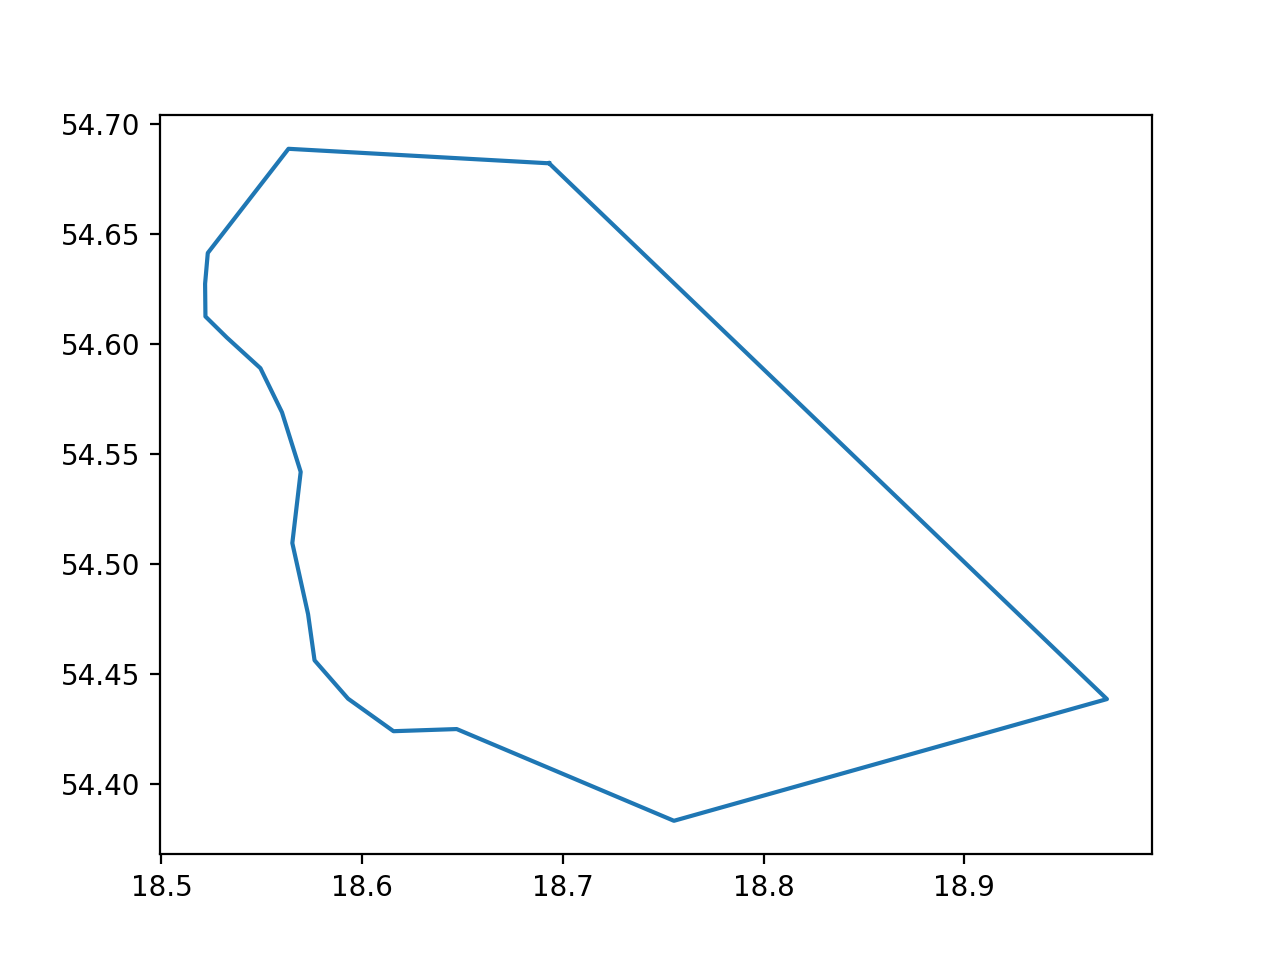

In [35]:
vector_file = 'data/vector/zatoka_v2.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)

In [36]:
vn = vector_data.reproject_geometry(epsg, True)

<IPython.core.display.Javascript object>


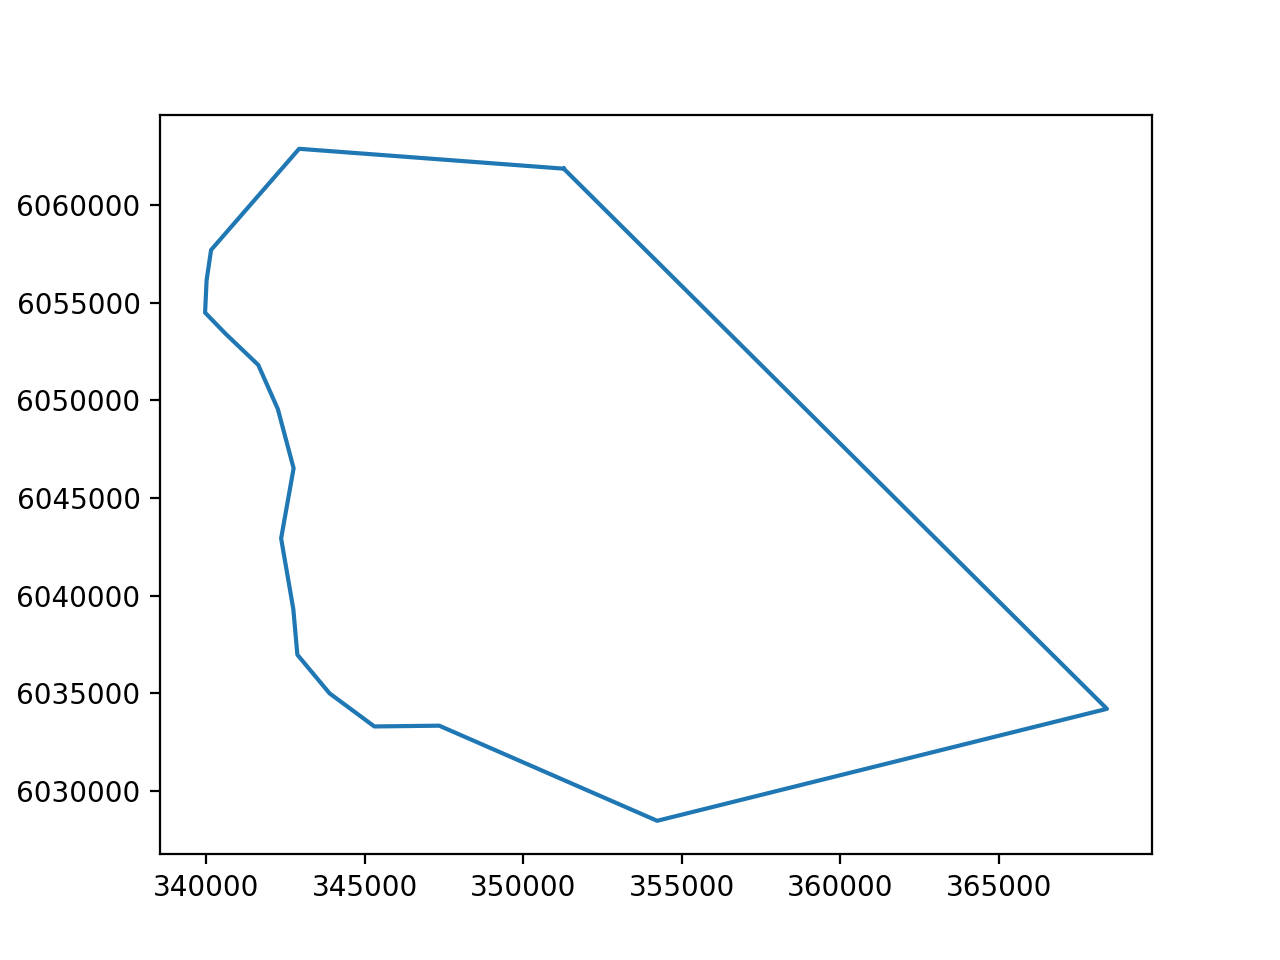

In [37]:
vector_data.show_vector_data(vn)

In [38]:
prepared_files = clip_all(dataset, vn, my_bands, my_folder_name)

File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-06-18.tif saved successfully
File: data/clipped/LC_band4_2013-06-18.tif saved successfully
File: data/clipped/LC_band5_2013-06-18.tif saved successfully
File: data/clipped/LC_band2_2013-08-05.tif saved successfully
File: data/clipped/LC_band4_2013-08-05.tif saved successfully
File: data/clipped/LC_band5_2013-08-05.tif saved successfully
File: data/clipped/LC_band2_2013-09-06.tif saved successfully
File: da

In [39]:
damaged_list = list(prepared_files[1].keys())
clean_dataset = dataset.drop(labels=damaged_list)
correct_df = pd.DataFrame.from_dict(prepared_files[0], orient='index')
clean_dataset = clean_dataset.join(correct_df)
clean_dataset

DIR  \
DATE                                                            
2013-04-15  data/rasters/LC081900222013041501T1-SC20180614...   
2013-05-01  data/rasters/LC081900222013050101T1-SC20180614...   
2013-05-17  data/rasters/LC081900222013051701T1-SC20180614...   
2013-06-18  data/rasters/LC081900222013061801T1-SC20180614...   
2013-08-05  data/rasters/LC081900222013080501T1-SC20180614...   
2013-09-06  data/rasters/LC081900222013090601T1-SC20180614...   
2014-07-07  data/rasters/LC081900222014070701T1-SC20180614...   
2015-04-21  data/rasters/LC081900222015042101T1-SC20180614...   
2015-08-11  data/rasters/LC081900222015081101T1-SC20180614...   
2017-04-10  data/rasters/LC081900222017041001T1-SC20180614...   
2017-05-12  data/rasters/LC081900222017051201T1-SC20180614...   
2017-05-28  data/rasters/LC081900222017052801T1-SC20180614...   
2018-04-13  data/rasters/LC081900222018041301T1-SC20180614...   
2018-05-31  data/rasters/LC081900222018053101RT-SC20180614...   

                                               0  \
DATE                                               
2013-04-15  data/clipped/LC_band2_2013-04-15.tif   
2013-05-01  data/clipped/LC_band2_2013-05-01.tif   
2013-05-17  data/clipped/LC_band2_2013-05-17.tif   
2013-06-18  data/clipped/LC_band2_2013-06-18.tif   
2013-08-05  data/clipped/LC_band2_2013-08-05.tif   
2013-09-06  data/clipped/LC_band2_2013-09-06.tif   
2014-07-07  data/clipped/LC_band2_2014-07-07.tif   
2015-04-21  data/clipped/LC_band2_2015-04-21.tif   
2015-08-11  data/clipped/LC_band2_2015-08-11.tif   
2017-04-10  data/clipped/LC_band2_2017-04-10.tif   
2017-05-12  data/clipped/LC_band2_2017-05-12.tif   
2017-05-28  data/clipped/LC_band2_2017-05-28.tif   
2018-04-13  data/clipped/LC_band2_2018-04-13.tif   
2018-05-31  data/clipped/LC_band2_2018-05-31.tif   

                                               1  \
DATE                                               
2013-04-15  data/clipped/LC_band4_2013-04-15.tif   
2013-05-01  data/clipped/LC_band4_2013-05-01.tif   
2013-05-17  data/clipped/LC_band4_2013-05-17.tif   
2013-06-18  data/clipped/LC_band4_2013-06-18.tif   
2013-08-05  data/clipped/LC_band4_2013-08-05.tif   
2013-09-06  data/clipped/LC_band4_2013-09-06.tif   
2014-07-07  data/clipped/LC_band4_2014-07-07.tif   
2015-04-21  data/clipped/LC_band4_2015-04-21.tif   
2015-08-11  data/clipped/LC_band4_2015-08-11.tif   
2017-04-10  data/clipped/LC_band4_2017-04-10.tif   
2017-05-12  data/clipped/LC_band4_2017-05-12.tif   
2017-05-28  data/clipped/LC_band4_2017-05-28.tif   
2018-04-13  data/clipped/LC_band4_2018-04-13.tif   
2018-05-31  data/clipped/LC_band4_2018-05-31.tif   

                                               2  
DATE                                              
2013-04-15  data/clipped/LC_band5_2013-04-15.tif  
2013-05-01  data/clipped/LC_band5_2013-05-01.tif  
2013-05-17  data/clipped/LC_band5_2013-05-17.tif  
2013-06-18  data/clipped/LC_band5_2013-06-18.tif  
2013-08-05  data/clipped/LC_band5_2013-08-05.tif  
2013-09-06  data/clipped/LC_band5_2013-09-06.tif  
2014-07-07  data/clipped/LC_band5_2014-07-07.tif  
2015-04-21  data/clipped/LC_band5_2015-04-21.tif  
2015-08-11  data/clipped/LC_band5_2015-08-11.tif  
2017-04-10  data/clipped/LC_band5_2017-04-10.tif  
2017-05-12  data/clipped/LC_band5_2017-05-12.tif  
2017-05-28  data/clipped/LC_band5_2017-05-28.tif  
2018-04-13  data/clipped/LC_band5_2018-04-13.tif  
2018-05-31  data/clipped/LC_band5_2018-05-31.tif

In [40]:
clean_dataset['EVI'] = clean_dataset.apply(lambda x: np.nanmean(calculate_evi([x[0], x[1], x[2]])), axis=1)

<IPython.core.display.Javascript object>


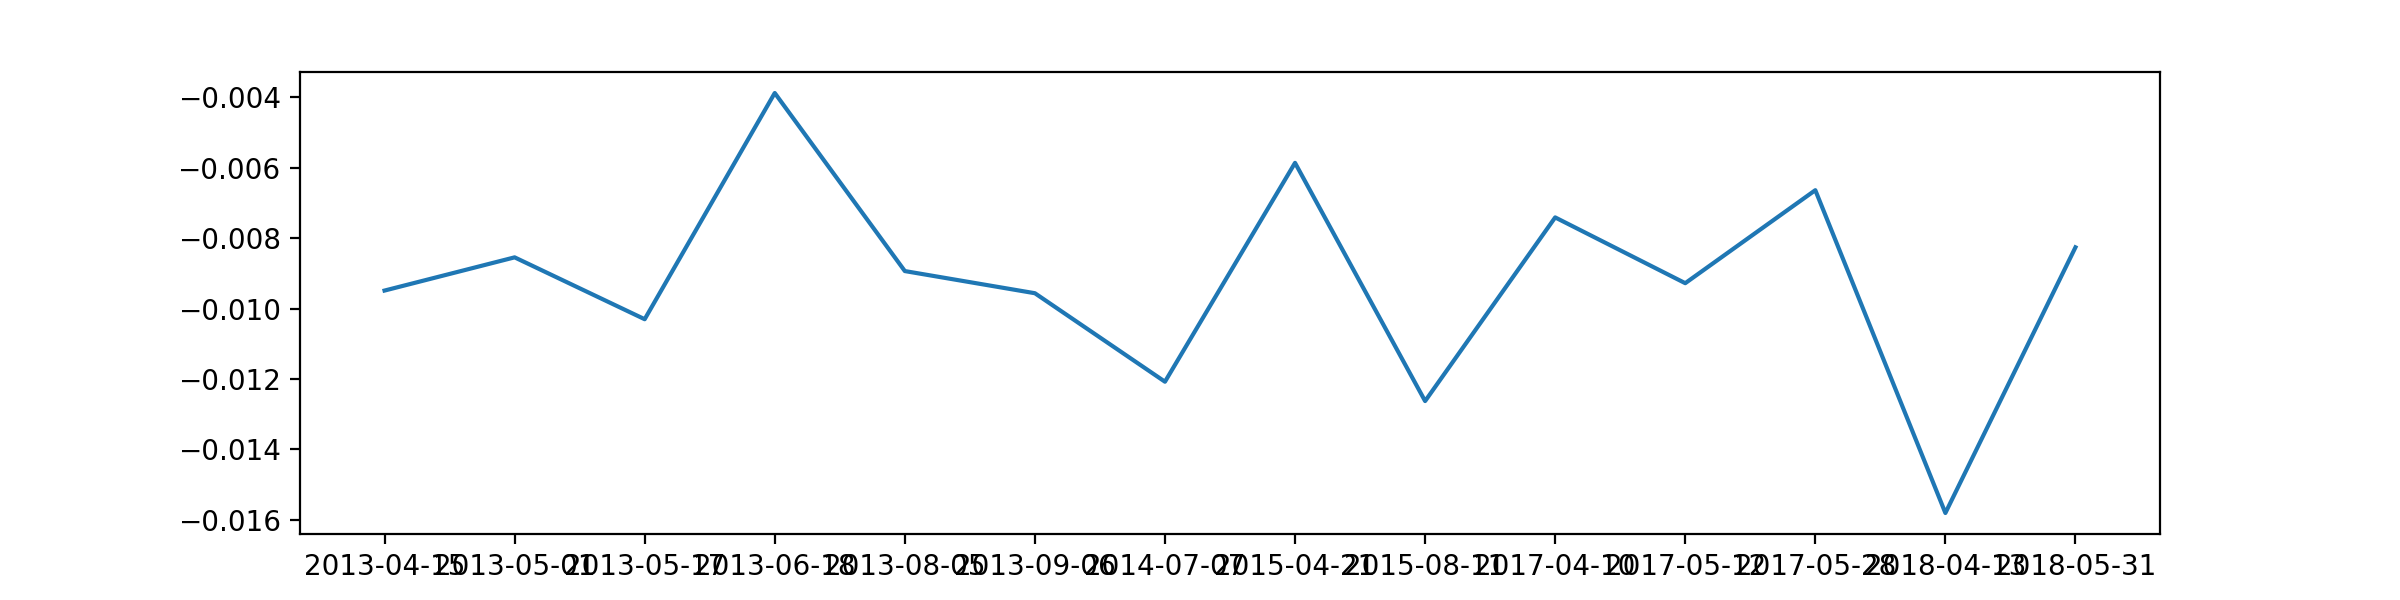

In [41]:
plt.figure(figsize=(12, 3))
plt.plot(clean_dataset.index, clean_dataset['EVI'])
plt.show()

<IPython.core.display.Javascript object>


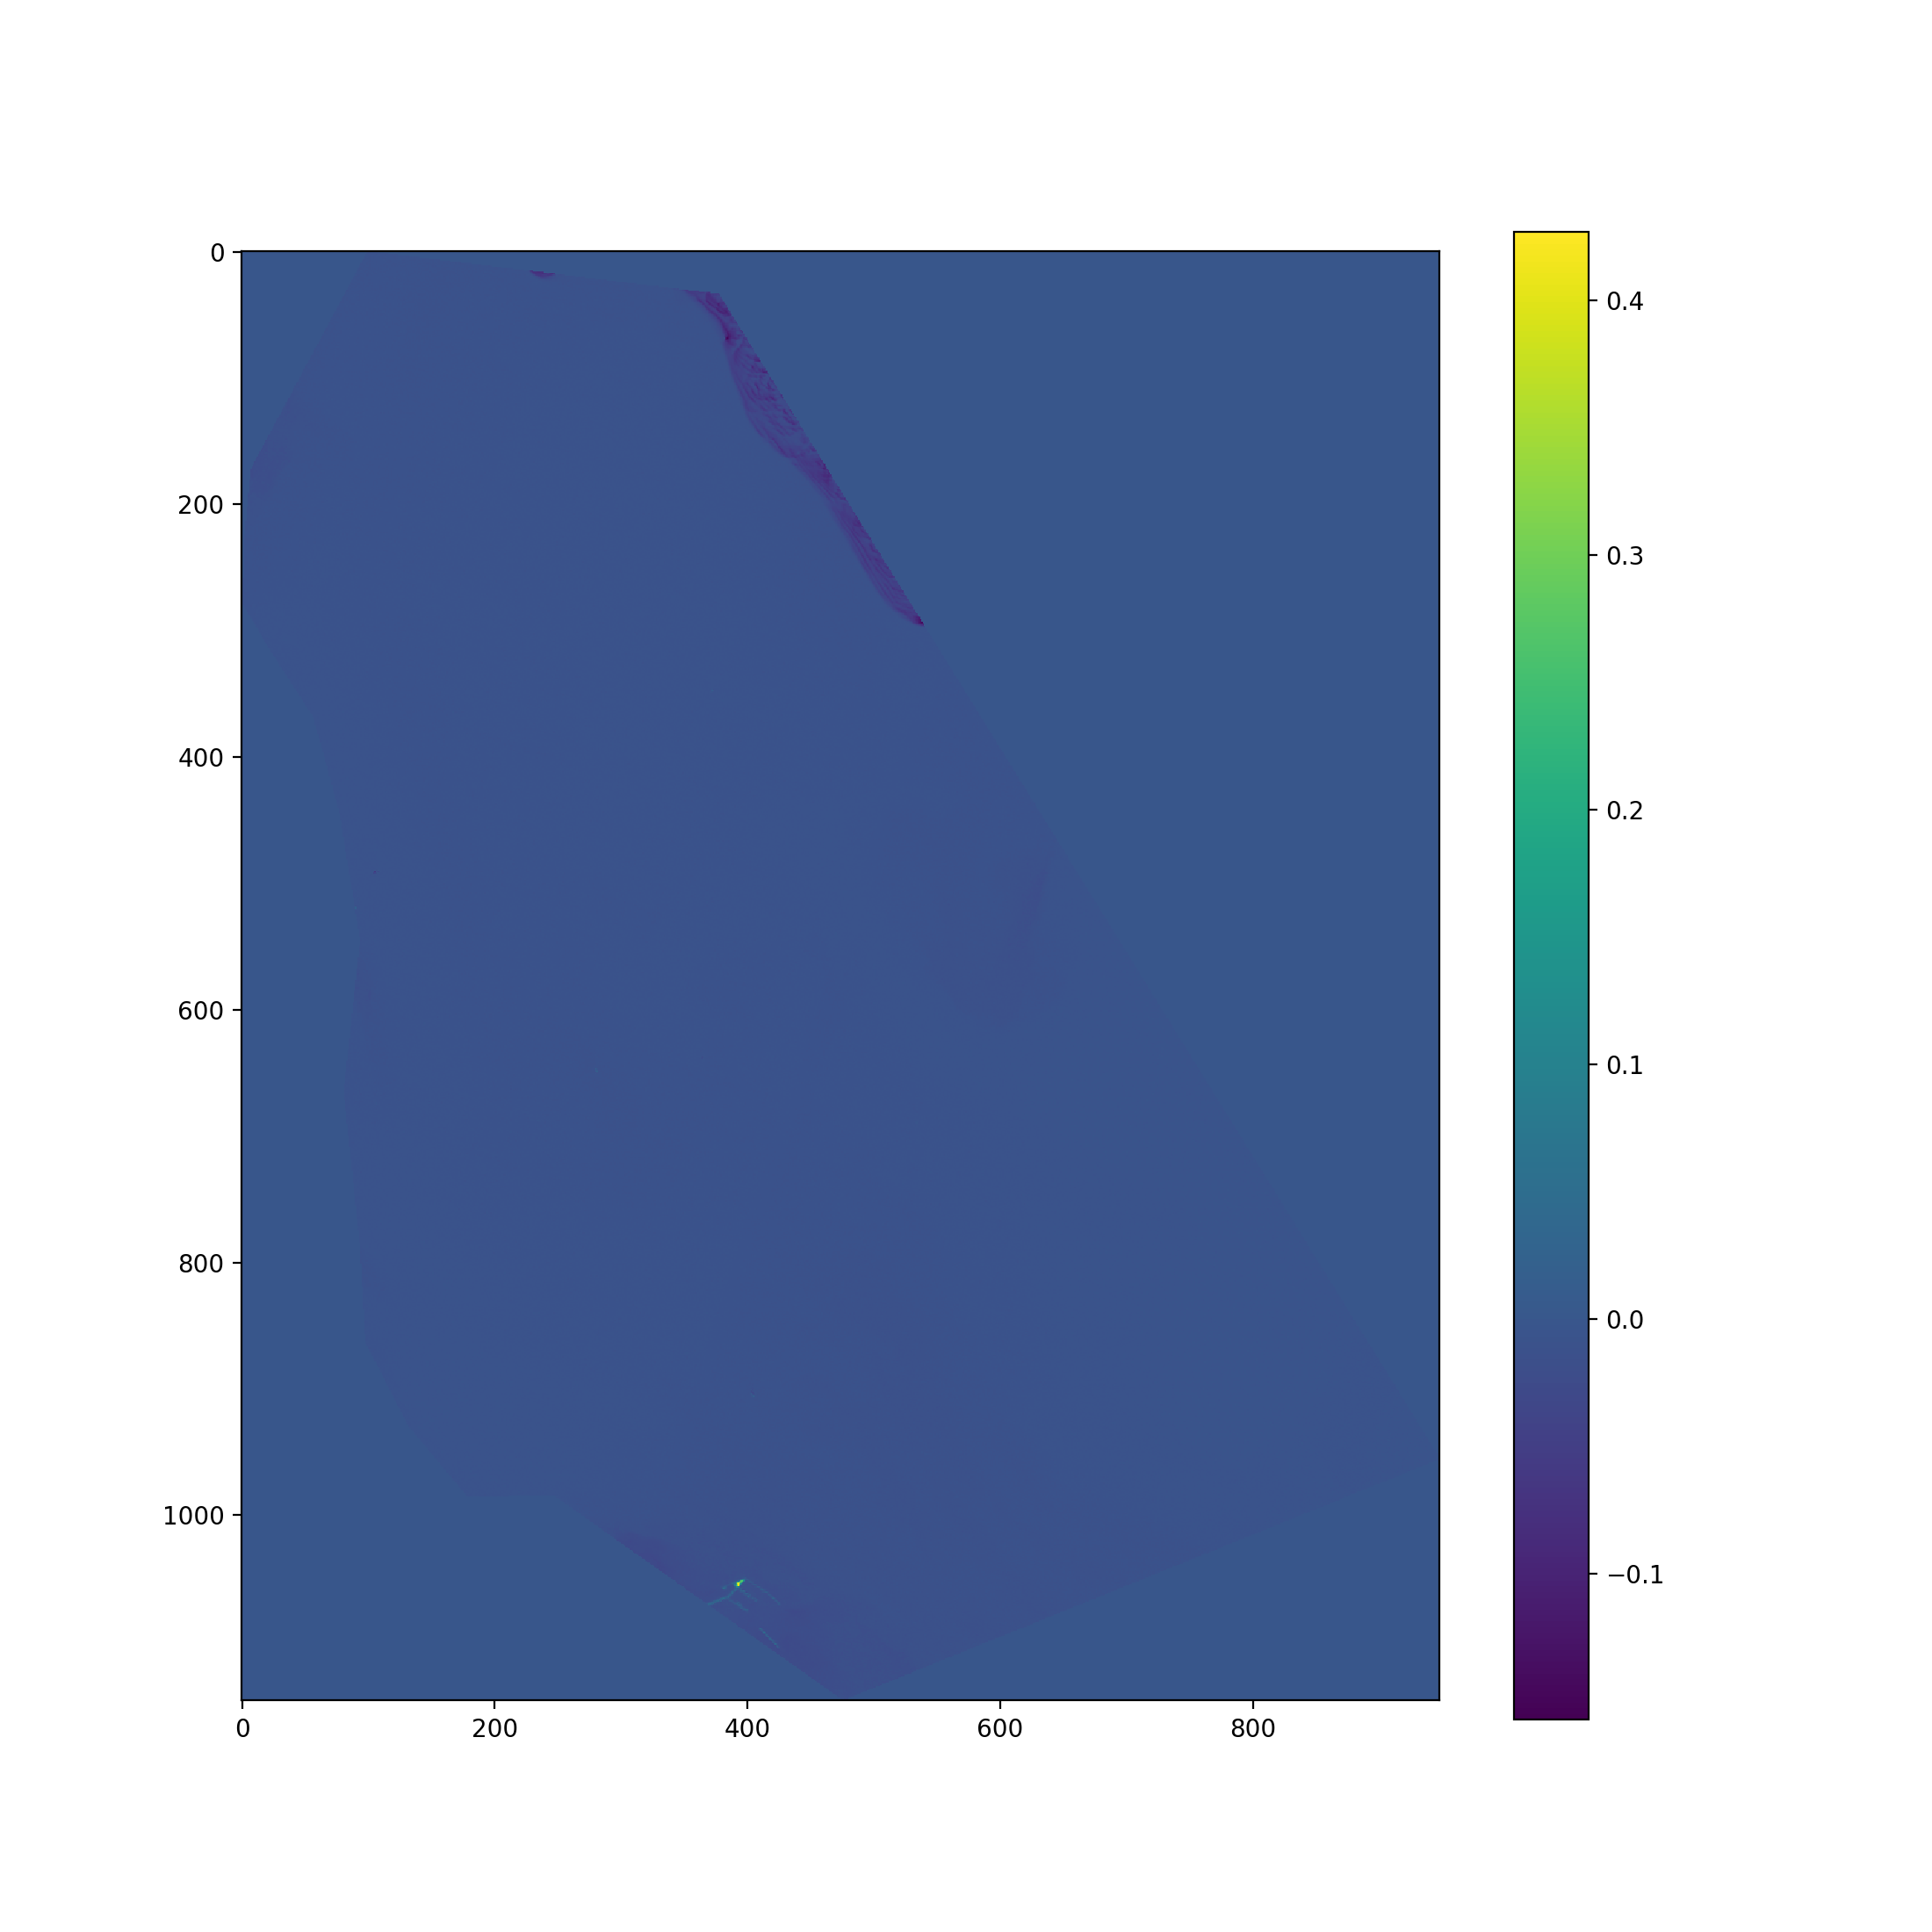

In [42]:
bands = [clean_dataset[clean_dataset.index == '2015-04-21'][0][0],
        clean_dataset[clean_dataset.index == '2015-04-21'][1][0],
        clean_dataset[clean_dataset.index == '2015-04-21'][2][0]]

before = calculate_evi(bands)
show_band(before, color_map='viridis', remove_negative=False)

<IPython.core.display.Javascript object>


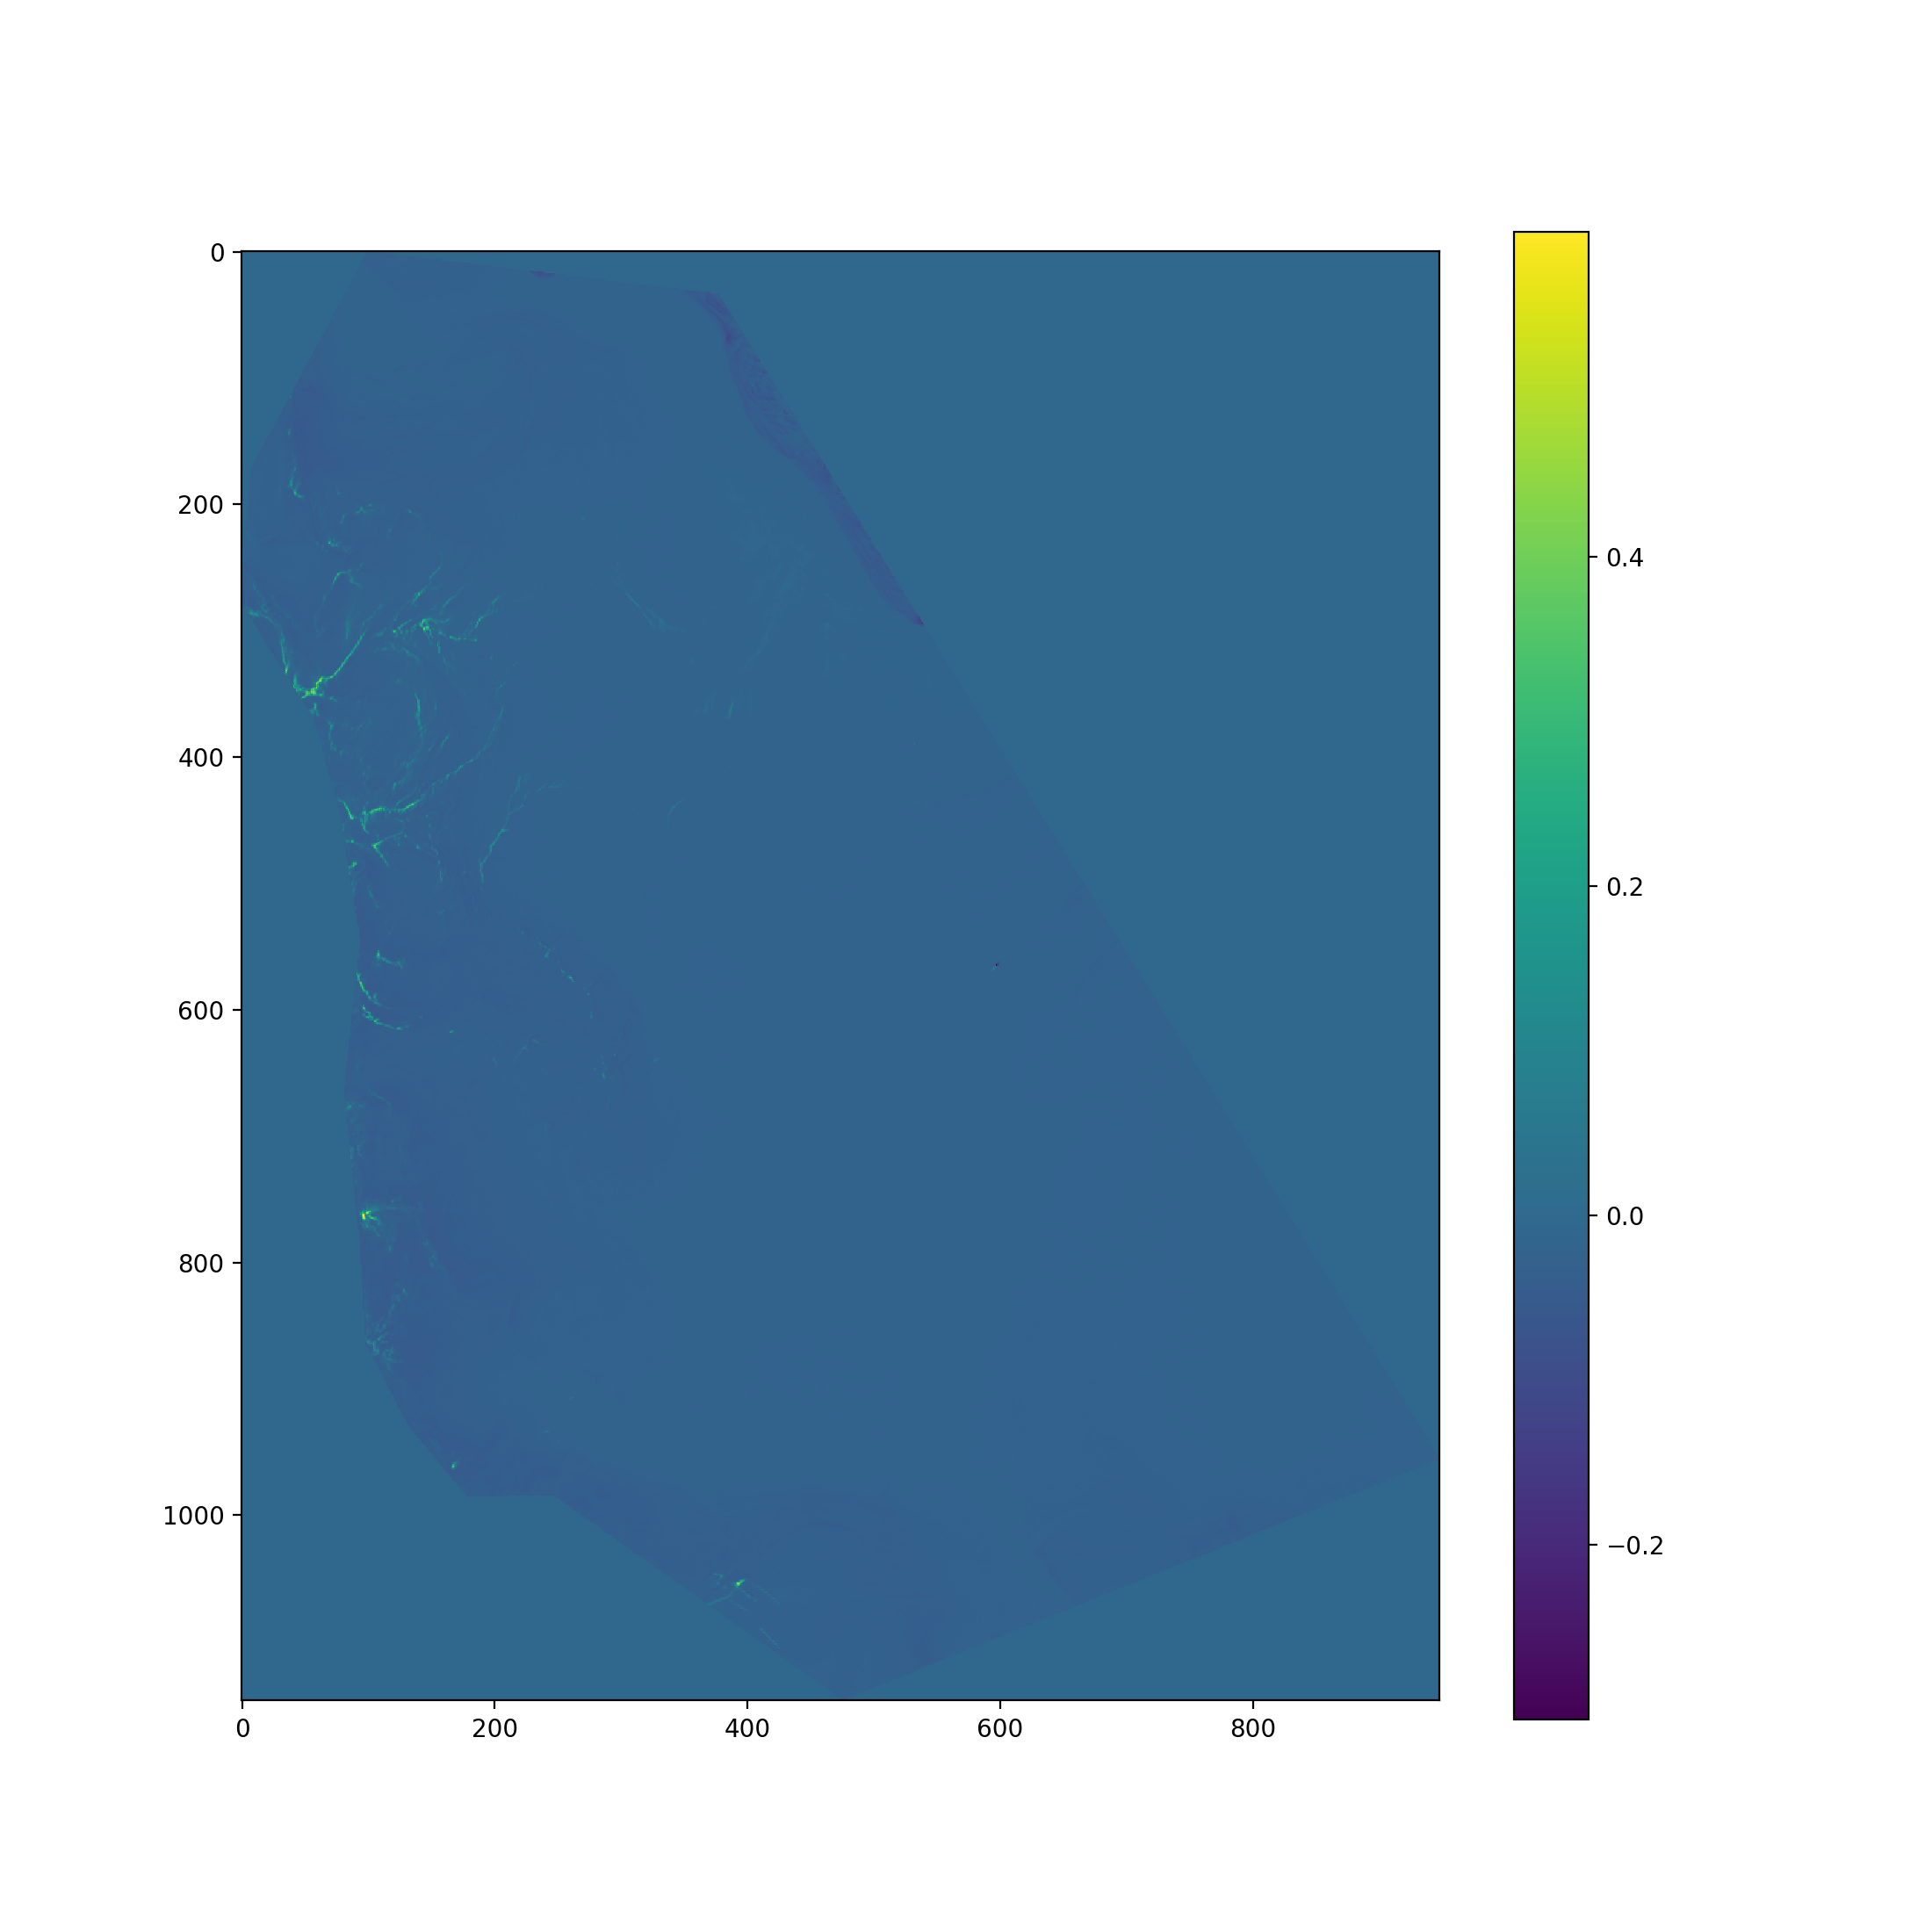

In [43]:
bands = [clean_dataset[clean_dataset.index == '2015-08-11'][0][0],
        clean_dataset[clean_dataset.index == '2015-08-11'][1][0],
        clean_dataset[clean_dataset.index == '2015-08-11'][2][0]]

after = calculate_evi(bands)
show_band(after, color_map='viridis', remove_negative=False)

<IPython.core.display.Javascript object>


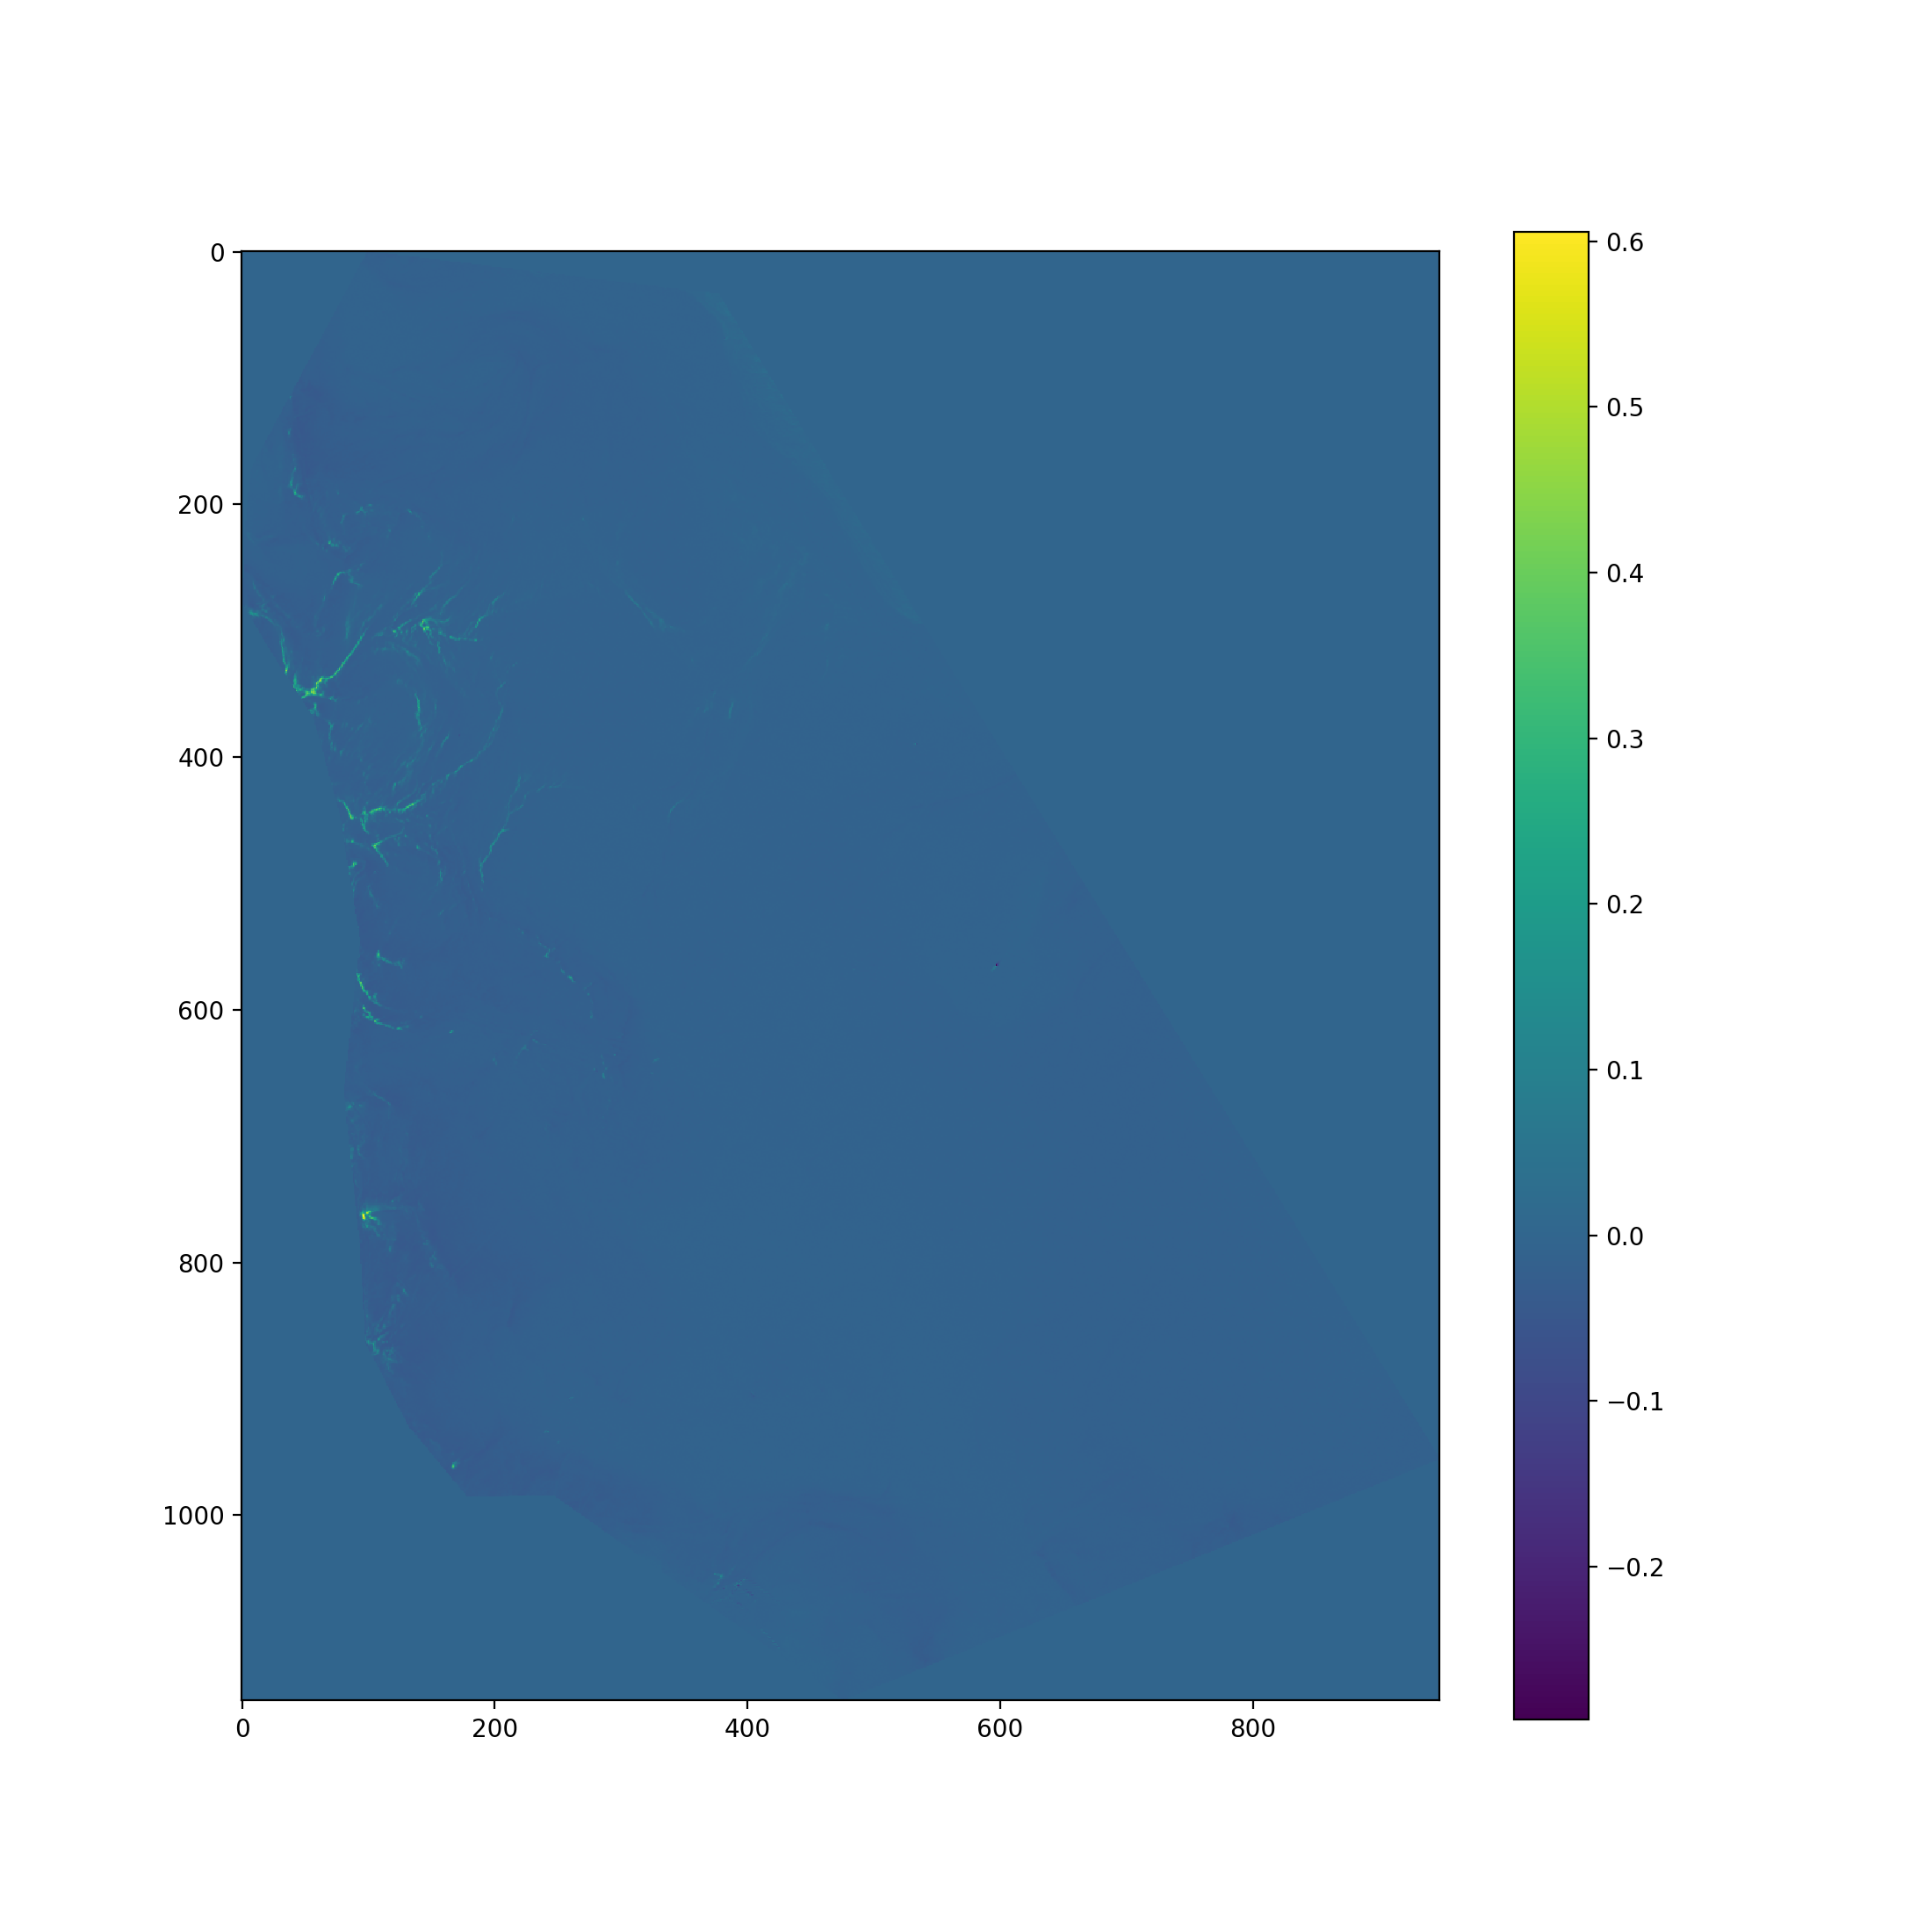

In [44]:
differences = after - before
show_band(differences, color_map='viridis', remove_negative=False)